# Import des modules et des fichiers CSV

In [225]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [226]:
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

# Nettoyage & analyse de 'customers'

## Customers : Diagnostic

In [227]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [228]:
customers.tail()
# numéro client avec seulement deux chiffres

,client_id,sex,birth
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968
8622,c_84,f,1982


In [229]:
customers.shape

(8623, 3)

In [230]:
customers.info()
# pas de NaN
# sex peut-être changé en 'category' afin de gagner en place

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [231]:
customers.describe()
# pas de valeur aberrante

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [232]:
customers.columns
#pas de problème d'espace dans les noms de colonnes

Index(['client_id', 'sex', 'birth'], dtype='object')

In [233]:
customers.client_id.value_counts()
#Pas de doublon dans les numéros de client --> clé primaire OK

c_4410    1
c_5441    1
c_5140    1
c_7935    1
c_7514    1
         ..
c_2797    1
c_818     1
c_3393    1
c_1497    1
c_84      1
Name: client_id, Length: 8623, dtype: int64

In [234]:
customers.sex.value_counts()
#pas de valeur autre que f/m

f    4491
m    4132
Name: sex, dtype: int64

In [235]:
list(customers.sex.value_counts().values)

[4491, 4132]

In [236]:
list(customers.sex.value_counts().values)

[4491, 4132]

In [237]:
help(plt.pie)

Help on function pie in module matplotlib.pyplot:

pie(x, explode=None, labels=None, colors=None, autopct=None, pctdistance=0.6, shadow=False, labeldistance=1.1, startangle=0, radius=1, counterclock=True, wedgeprops=None, textprops=None, center=(0, 0), frame=False, rotatelabels=False, *, normalize=True, data=None)
    Plot a pie chart.
    
    Make a pie chart of array *x*.  The fractional area of each wedge is
    given by ``x/sum(x)``.
    
    The wedges are plotted counterclockwise, by default starting from the
    x-axis.
    
    Parameters
    ----------
    x : 1D array-like
        The wedge sizes.
    
    explode : array-like, default: None
        If not *None*, is a ``len(x)`` array which specifies the fraction
        of the radius with which to offset each wedge.
    
    labels : list, default: None
        A sequence of strings providing the labels for each wedge
    
    colors : array-like, default: None
        A sequence of colors through which the pie chart will 

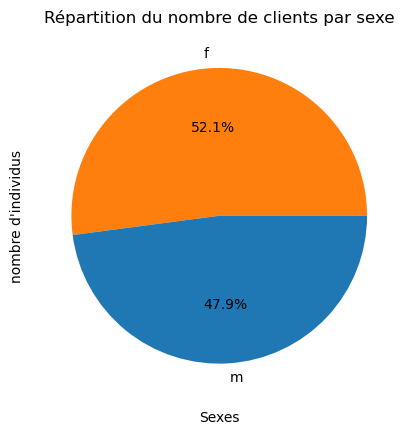

In [238]:
# visualisation des clients par sexe

plt.pie(customers.sex.value_counts(), labels=(customers.sex.value_counts().index), autopct='%1.1f%%', colors=('tab:orange', 'tab:blue'))
plt.title('Répartition du nombre de clients par sexe')
plt.xlabel('Sexes')
plt.ylabel('''nombre d'individus''')
plt.savefig('repartion_par_sexes')
plt.show()

## Nombre de clients par année de naissance

In [239]:
# On compte le nombre de clients en les regroupant par leur année de naissance
birth_count = customers.groupby('birth').count()

In [240]:
birth_count.reset_index(inplace= True)

In [241]:
# Sélection des colonnes
birth_count = birth_count[['birth', 'client_id']]
# changement de nom des colonnes
birth_count.columns = ['birth', 'nb_client']
birth_count

,birth,nb_client
0,1929,3
1,1930,4
2,1931,4
3,1932,6
4,1933,8
...,...,...
71,2000,136
72,2001,129
73,2002,146
74,2003,146


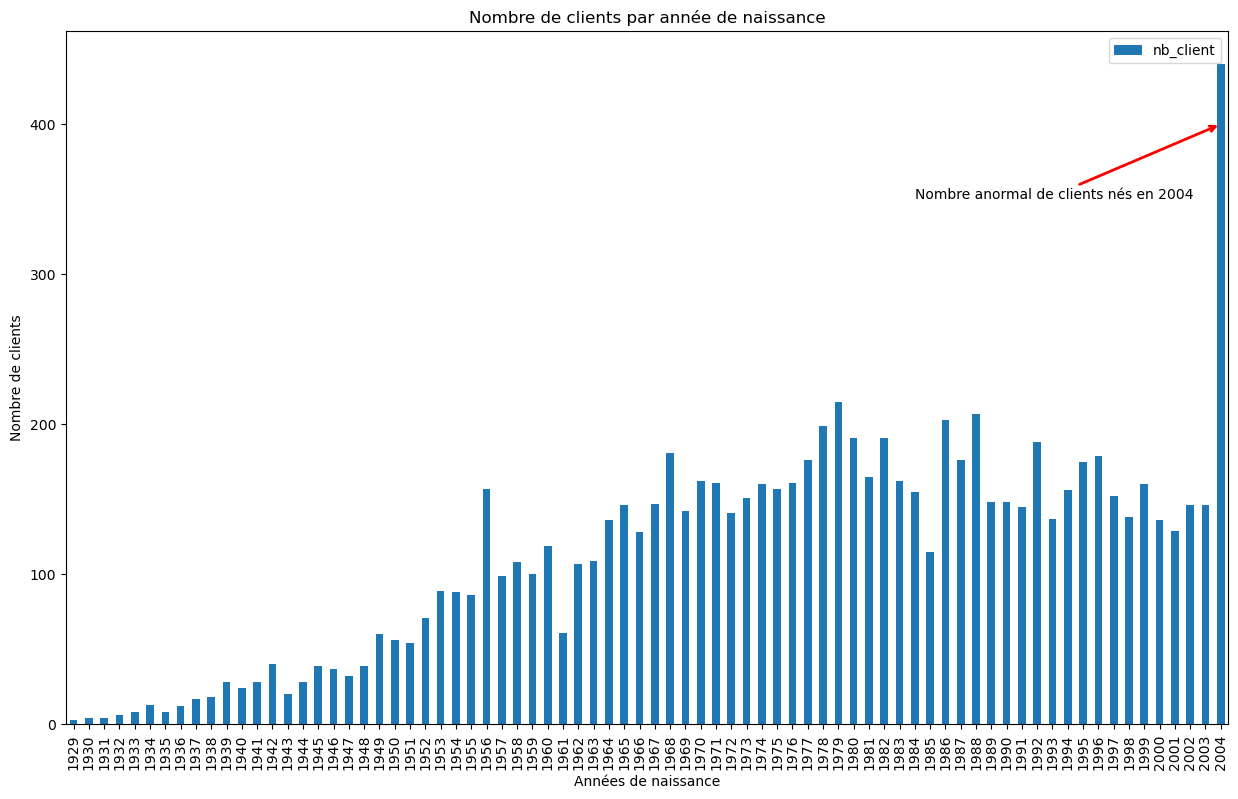

In [242]:
# visualisation du nombre de clients par année de naissance en utilisant un diagramme à bars

birth_count.plot(x='birth', y='nb_client', kind='bar', figsize=(15,9))
plt.title('Nombre de clients par année de naissance')
plt.xlabel('Années de naissance')
plt.ylabel('Nombre de clients')
plt.annotate('Nombre anormal de clients nés en 2004', xy=(75,400), xytext=(55,350),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.savefig('clients_par_naissance')
plt.show()

# l'année de naissance 2004 correspondant à l'âge de 18ans, est fortement représenté, 
# ce qui laisse penser que beaucoup d'acheteur ont moins de 18 ans et utilise l'année de naissance minimum

### Transformation de la colonne "sex" de 'object' (chaîne de caractère) à 'category'

In [243]:
# Définition du type de la variable 'sex' vers une variable du type 'catégory'
customers.sex = customers.sex.astype('category')

In [244]:
customers.info()
# On passe de 202 KB à 143 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   client_id  8623 non-null   object  
 1   sex        8623 non-null   category
 2   birth      8623 non-null   int64   
dtypes: category(1), int64(1), object(1)
memory usage: 143.4+ KB


### Identification des numéros de client avec un format différent de 'c_xxxx'

In [245]:
pattern = re.compile('c_\d*') # création d'un pattern standard
mask= customers.client_id.str.contains(pattern)
print(customers.client_id[~mask]) # utilisation du tilde pour identifier les entrées qui ne correspondent pas au pattern
ct_list = list(customers.client_id[~mask]) # Sauvegarde des client_id du format 'ct_x' dans une liste
display(customers[customers.client_id.isin(ct_list)])

2735    ct_0
8494    ct_1
Name: client_id, dtype: object


,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


# Nettoyage de 'products'

## Products : diagnostic

In [246]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [247]:
products.tail()

,id_prod,price,categ
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


In [248]:
products.shape

(3287, 3)

In [249]:
products.columns
#Pas d'espace en trop

Index(['id_prod', 'price', 'categ'], dtype='object')

In [250]:
products.info()
# Pas de NaN 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


### Description générale

In [251]:
products.describe()
# prix négatif --> analyser le -1 dans transac
# indicateurs de dispersion élevés, préféré une description par categ

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


### Description par catégorie

In [252]:
# Groupement des données par catégorie avec pour fonction d'aggrégation .describe()
products_describe = products.groupby('categ')['price'].describe()
products_describe

,count,mean,std,min,25%,50%,75%,max
categ,,,,,,,,
0,2309.0,11.727280,7.568756,-1.00,5.580,10.32,16.65,40.99
1,739.0,25.531421,15.425162,2.00,13.390,22.99,33.99,80.99
2,239.0,108.354686,49.561431,30.99,71.065,101.99,136.53,300.00


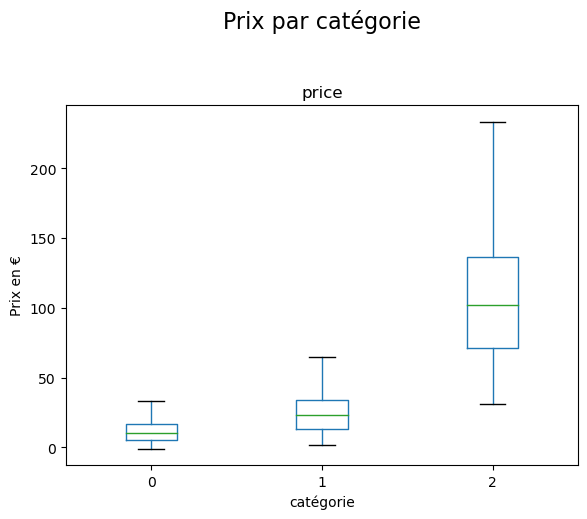

In [253]:
# Boîtes à moustache de la distribution des prix en fonction de la catégorie
# Version sans les valeurs aberrantes
products.boxplot(column='price', by='categ', showfliers=False, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1)
plt.xlabel('catégorie')
plt.ylabel('Prix en €')
plt.savefig('prix_categ')
plt.show()

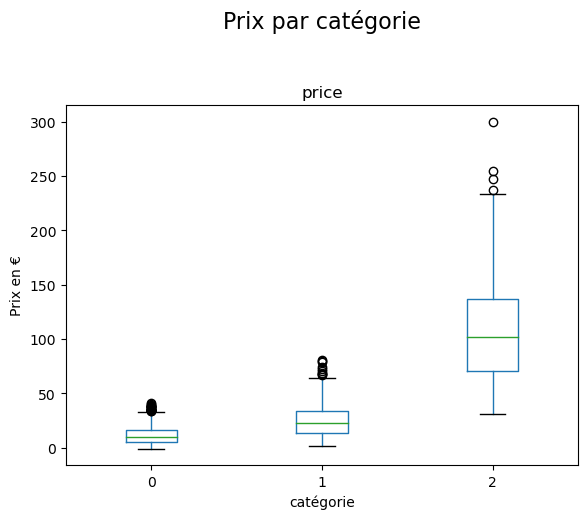

In [254]:
# Avec les valeurs aberrantes
products.boxplot(column='price', by='categ', showfliers=True, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1)
plt.xlabel('catégorie')
plt.ylabel('Prix en €')
plt.savefig('prix_categ_outliers')

### Clé primaire

In [255]:
# est-ce que id_prod est une clé primaire candidate ?
products.id_prod.value_counts()
# Pas de doublons --> clé primaire potentiel

0_1421    1
0_2298    1
0_870     1
0_1785    1
0_1876    1
         ..
0_2155    1
0_1118    1
2_12      1
2_20      1
0_1920    1
Name: id_prod, Length: 3287, dtype: int64

In [256]:
products.categ.value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

### Identification du produit ayant une valeur négatif

In [257]:
# on sauvegarde le numéro produit de l'article avec un prix négatif

id_product_neg = products[products.price == -1]['id_prod'].values
id_product_neg = id_product_neg[0]
products[products.id_prod == id_product_neg]

,id_prod,price,categ
731,T_0,-1.0,0


## Products : modifications

### Modification du type de 'categ' d'objet à catégorie

In [258]:
products.categ = products.categ.astype('category')

In [259]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [260]:
products.info()
# de 77 KB à 54.8 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id_prod  3287 non-null   object  
 1   price    3287 non-null   float64 
 2   categ    3287 non-null   category
dtypes: category(1), float64(1), object(1)
memory usage: 54.8+ KB


## Products : Représentation graphique de la distribution des prix en fonction de la catégorie

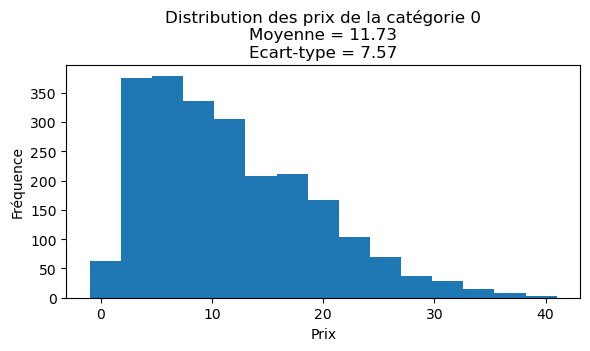

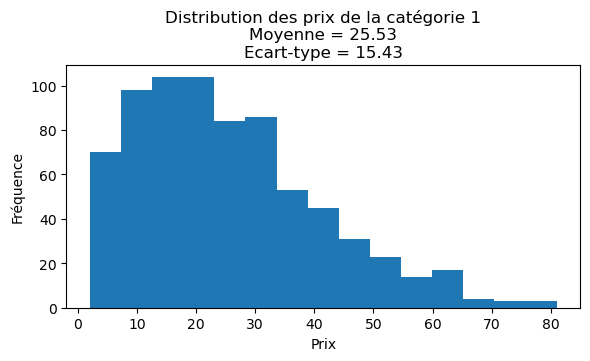

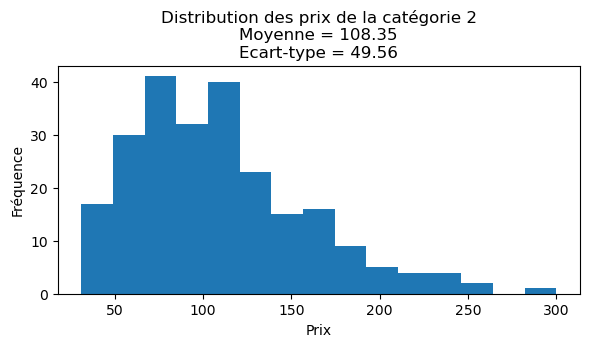

In [261]:
### création d'une boucle qui va retourner un histogramme, la moyenne, et l'écart-type des prix en fonction de la catégorie


i=0

while i < 3 :
    mu = products_describe.loc[i,'mean']
    sigma = products_describe.loc[i,'std']
    plt.subplot(3,1,i+1)
    plt.gcf().set_size_inches(6,9)
    plt.hist(products[products.categ == i]['price'], bins=15 )
    plt.title('Distribution des prix de la catégorie ' + str(i) + '\n' + 'Moyenne = ' + str(round(mu,2)) + '\n' + 'Ecart-type = ' + str(round(sigma,2)))
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    plt.tight_layout()
    plt.savefig('distribution_prix'+ str(i))
    plt.show()
    i += 1

# Nettoyage de 'transactions'

## Transactions : diagnostic

In [262]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [263]:
transactions.tail()

,id_prod,date,session_id,client_id
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5
337015,0_1417,2021-06-26 14:38:19.732946,s_54117,c_6714


In [264]:
transactions.shape

(337016, 4)

In [265]:
transactions.info()
#Pas de NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [266]:
transactions.columns
#Pas d'espace en trop dans les noms de variables

Index(['id_prod', 'date', 'session_id', 'client_id'], dtype='object')

In [267]:
transactions.describe()

,id_prod,date,session_id,client_id
count,337016,337016,337016,337016
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,1081,13,200,12855


### Clé primaire

In [268]:
# Test d'unicité
transactions.session_id.value_counts()
# les enregistrements de la variable session_id ne sont pas uniques. En effet, une session peut contenir plusieurs achats

s_0         200
s_118668     14
s_96857      13
s_21005      13
s_168560     12
           ... 
s_26281       1
s_73468       1
s_169637      1
s_131653      1
s_112349      1
Name: session_id, Length: 169195, dtype: int64

### Unicité des dates

In [269]:
transactions.date.value_counts()
# il est possible d'avoir des doublons dans la date lors par exemple de test
# Cependant, les dates sont enregistrées avec les heures (jusque à la nanoseconde), il est très peu probable d'avoir un doublon pour un achat standard
# De plus, il serait intéressant de contacter le data architect (ou équivalent dans l'entreprise) pour savoir s'il existe un mécanisme qui empêche la duplicité d'une date
# En supprimant, les enregistrements tests la date pourrait être une clé primaire candidate

test_2021-03-01 02:30:02.237413    13
test_2021-03-01 02:30:02.237444     8
test_2021-03-01 02:30:02.237414     8
test_2021-03-01 02:30:02.237443     8
test_2021-03-01 02:30:02.237427     8
                                   ..
2022-02-09 22:59:58.462372          1
2021-07-12 16:51:13.050588          1
2021-05-16 13:56:49.552487          1
2021-09-15 13:10:57.053224          1
2021-06-26 14:38:19.732946          1
Name: date, Length: 336855, dtype: int64

## Transactions : Modification

### Création d'un pattern pour la date

In [270]:
id_product_neg

'T_0'

In [271]:
pattern_date = re.compile('^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.\d{6}') # Création du pattern 
transactions[~transactions.date.str.contains(pattern_date)]

# id_prod T_0 correspond au produit avec un prix négatif
# ct_x signifie 'client test'
# s_0 est une session test

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


In [272]:
date_test_index = transactions[~transactions.date.str.contains(pattern_date)].index # identification des index qui ne correspondent pas au pattern
transactions.drop(date_test_index, inplace=True) # Suppression
display(transactions.date.value_counts()) # plus de doublon, est-ce que c'est une bonne clé primaire pour autant ?
transactions.date = pd.to_datetime(transactions.date, format='%Y-%m-%d %H:%M:%S.%f') # Modification du type de la variable de chaîne de caractère à date
transactions.sort_values('date', inplace=True) # je trie les dates par ordre chronologique
transactions.reset_index(inplace=True) # réinialisation de l'index par rapport à la date
transactions.drop('index', axis=1, inplace=True) # Suppression de l'ancien index
transactions = transactions[['date', 'session_id', 'client_id', 'id_prod']] # Réagencemment des colonnes

2021-04-10 18:37:28.723910    1
2022-02-11 23:34:46.153414    1
2021-05-21 10:06:01.528062    1
2021-04-29 03:17:06.173957    1
2021-08-25 05:59:00.755992    1
                             ..
2022-02-09 22:59:58.462372    1
2021-07-12 16:51:13.050588    1
2021-05-16 13:56:49.552487    1
2021-09-15 13:10:57.053224    1
2021-06-26 14:38:19.732946    1
Name: date, Length: 336816, dtype: int64

In [273]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        336816 non-null  datetime64[ns]
 1   session_id  336816 non-null  object        
 2   client_id   336816 non-null  object        
 3   id_prod     336816 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 10.3+ MB


## Vérification avant jointure : exploration des données manquantes et aberrantes

### Transactions avec le code client du type 'ct_x' ou avec un prix négatif

In [274]:
transactions[transactions.client_id.isin(ct_list)]

# Aucune transaction avec les client_id ct_x car elles ont été supprimé avec les dates test



,date,session_id,client_id,id_prod


In [275]:
transactions[transactions.id_prod == id_product_neg]

# Aucune transaction avec le id_prod avec un prix négatif car elles ont été supprimé avec les dates test

,date,session_id,client_id,id_prod


### Transactions avec un code client qui n'est pas dans la base customers

In [276]:
transactions[~transactions.client_id.isin(customers.client_id.unique())]

# Pas de client manquant

,date,session_id,client_id,id_prod


### Transactions avec un produit qui n'est pas présent dans la table products

In [277]:
transactions[~transactions.id_prod.isin(products.id_prod.unique())]
# Il existe un produit dans transactions qui n'est pas dans présent dans la table products

,date,session_id,client_id,id_prod
9,2021-03-01 00:09:29.301897,s_3,c_580,0_2245
1581,2021-03-02 15:55:49.728644,s_783,c_8060,0_2245
6366,2021-03-07 20:00:01.525768,s_3159,c_1189,0_2245
21042,2021-03-23 15:57:44.266387,s_10427,c_5869,0_2245
25330,2021-03-28 10:46:04.804784,s_12567,c_966,0_2245
...,...,...,...,...
327442,2022-02-20 03:50:42.646180,s_167926,c_7287,0_2245
331712,2022-02-24 04:18:45.054650,s_169978,c_5953,0_2245
332574,2022-02-25 00:08:08.736068,s_170426,c_6236,0_2245
332854,2022-02-25 06:36:49.557289,s_170548,c_2242,0_2245


### Ajout du produit manquant à la table 'products', prix à la médiane

In [278]:
products.append({'id_prod': '0_2245', 'price' : products_describe.loc[0,'50%'], 'categ' : 0}, ignore_index=True)

#std faible --> bonne chose

/tmp/ipykernel_107731/613949928.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  products.append({'id_prod': '0_2245', 'price' : products_describe.loc[0,'50%'], 'categ' : 0}, ignore_index=True)


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


# Jointure des tables

## Jointure à gauche (transactions) avec customers sur 'client_id'

In [279]:
#jointure entre transactions et customers
data = pd.merge(transactions, customers, on='client_id')

## Jointure à gauche (précédent DF joint entre transactions et customers) avec products sur 'id_prod'

In [280]:
#jointure entre data et products
data = pd.merge(data, products, on='id_prod')

In [281]:
data.head()

,date,session_id,client_id,id_prod,sex,birth,price,categ
0,2021-03-01 00:01:07.843138,s_1,c_329,0_1259,f,1967,11.99,0
1,2021-03-04 07:26:01.343183,s_1519,c_1609,0_1259,m,1980,11.99,0
2,2021-06-24 09:40:37.526181,s_53058,c_1609,0_1259,m,1980,11.99,0
3,2021-06-24 14:40:37.428842,s_53165,c_1609,0_1259,m,1980,11.99,0
4,2021-09-26 21:30:08.966835,s_96014,c_1609,0_1259,m,1980,11.99,0


## Vérification après jointure

#### ct_list et id_prod_neg dans data ?

In [282]:
data.loc[(data.client_id.isin(ct_list))|(data.id_prod == id_product_neg)]

# Non

,date,session_id,client_id,id_prod,sex,birth,price,categ


#### Est-ce que le premier  chiffre de id_prod est toujours égale à la catégorie ?

In [283]:
test1 = data.id_prod.str[0:1].astype('float').rename('test')
test2 = data.categ.astype('float').rename('test')
pd.testing.assert_series_equal(test1, test2)

# Pas de résultats --> les séries sont identiques
# Pour chaque produit, le premier chiffre de id_prod correspond bien à la catégorie 

### Tri des transactions par date

In [284]:
data = data.set_index('date') # 'date' devient l'index
data.sort_values('date') # tri des données par date

,session_id,client_id,id_prod,sex,birth,price,categ
date,,,,,,,
2021-03-01 00:01:07.843138,s_1,c_329,0_1259,f,1967,11.99,0
2021-03-01 00:02:26.047414,s_2,c_664,0_1390,m,1960,19.37,0
2021-03-01 00:02:38.311413,s_3,c_580,0_1352,m,1988,4.50,0
2021-03-01 00:04:54.559692,s_4,c_7912,0_1458,f,1989,6.55,0
2021-03-01 00:05:18.801198,s_5,c_2033,0_1358,f,1956,16.49,0
...,...,...,...,...,...,...,...
2022-02-28 23:56:57.196281,s_172422,c_5787,1_456,f,1986,28.27,1
2022-02-28 23:56:57.561424,s_172423,c_1460,1_370,m,1989,13.11,1
2022-02-28 23:57:12.741573,s_172424,c_1876,0_1538,m,1983,8.61,0


# Data : calcul des indicateurs

## Chiffre d'affaires par mois

In [285]:
ca_m = data.resample('M')[['price']].sum()
ca_m

# Echantillionage des données par mois grâce à l'index date

,price
date,
2021-03-31,479312.03
2021-04-30,472980.72
2021-05-31,489367.95
2021-06-30,481257.94
2021-07-31,480898.66
2021-08-31,479305.19
2021-09-30,502771.28
2021-10-31,319159.96
2021-11-30,512890.17


In [286]:
total_CA = ca_m['price'].sum() # Montant du chiffre d'affaires total
total_CA

5796577.77

## Taux de croissance du CA par mois

In [287]:
# Création d'une boucle pour calculer le taux de croissance du CA d'un mois à l'autre

i = 1 # compteur
growth_rate=[0] # iniatilisation de la liste, départ à 0 pour le premier mois

while i < len(ca_m.values): # on continue la boucle tant qu'il y a des valeurs dans la série
    var = ((ca_m.values[i] - ca_m.values[i-1]) / ca_m.values[i-1]) * 100 # calcul du ratio
    i +=1 # incrémentation
    growth_rate.append(round(float(var),3)) # ajout de la valeur arrondie à la liste
print(growth_rate)

[0, -1.321, 3.465, -1.657, -0.075, -0.331, 4.896, -36.52, 60.7, 1.959, 0.003, 1.871]


In [288]:
# ajout de la liste au df ca_m
ca_m['growth_rate_percentage'] = growth_rate 
ca_m.head(12)

,price,growth_rate_percentage
date,,
2021-03-31,479312.03,0.000
2021-04-30,472980.72,-1.321
2021-05-31,489367.95,3.465
2021-06-30,481257.94,-1.657
2021-07-31,480898.66,-0.075
2021-08-31,479305.19,-0.331
2021-09-30,502771.28,4.896
2021-10-31,319159.96,-36.520
2021-11-30,512890.17,60.700


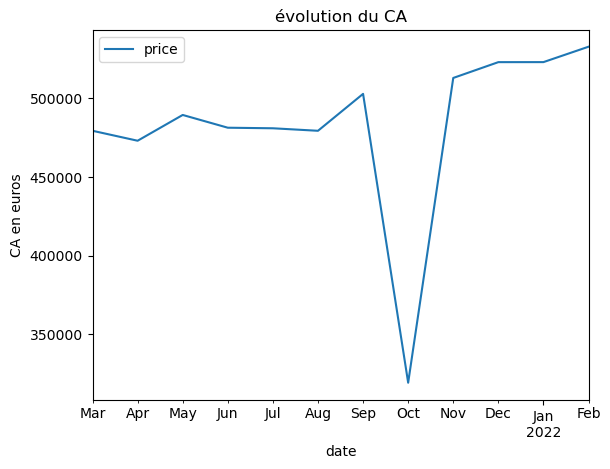

In [289]:
ca_m['price'].plot(legend=True)
plt.title('évolution du CA')
plt.ylabel('CA en euros')
plt.savefig('CA_mensuel')
plt.show()

# Baisse très importante du CA en octobre. Lien avec la rentrée scolaire de septembre ?

## Exploration de la baisse d'octobre

### Manque t-il des jours ?

In [290]:
data['2021-Oct'].resample('D')['price'].sum()

# Pas de jour manquant 

/tmp/ipykernel_107731/840215636.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2021-Oct'].resample('D')['price'].sum()


date
2021-10-01    16909.36
2021-10-02     9033.15
2021-10-03     8844.07
2021-10-04     9130.70
2021-10-05     9390.46
2021-10-06     9341.71
2021-10-07     8191.08
2021-10-08    10207.35
2021-10-09     9425.36
2021-10-10     8676.67
2021-10-11    10230.56
2021-10-12     8822.17
2021-10-13     9427.22
2021-10-14     9320.80
2021-10-15     9249.85
2021-10-16    10229.02
2021-10-17     9557.98
2021-10-18     9083.72
2021-10-19     8601.71
2021-10-20     9021.19
2021-10-21     9571.79
2021-10-22     8318.88
2021-10-23     8910.64
2021-10-24     9923.19
2021-10-25     8076.04
2021-10-26     8871.81
2021-10-27     9789.53
2021-10-28    14758.42
2021-10-29    16453.63
2021-10-30    15386.78
2021-10-31    16405.12
Freq: D, Name: price, dtype: float64

### Analyse des catégories

#### CA mensuel moyen par catégorie

In [291]:
categ_avg = data.groupby('categ')['price'].sum() / 12 # Chiffre d'affaires regroupé par catégorie et divisé par 12
categ_avg.to_numpy()

array([185810.22083333, 187282.03416667, 109955.8925    ])

In [292]:
categ_oct = data['2021-Oct'].groupby('categ')['price'].sum()
categ_oct
# CA par categ au mois d'octobre

/tmp/ipykernel_107731/2546265884.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  categ_oct = data['2021-Oct'].groupby('categ')['price'].sum()


categ
0    199217.94
1     33762.32
2     86179.70
Name: price, dtype: float64

#### Comparaison en le CA mensuel moyen par catégorie et le CA moyen par catégorie d'Octobre

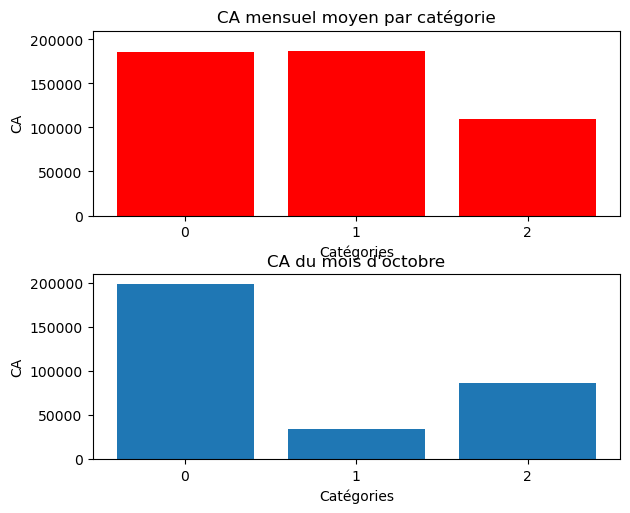

In [293]:
# Création de deux graphiques, l'un avec le CA moyen par catégorie et l'autre avec le CA par catégorie d'Octobre


plt.subplot(2,1,1)
plt.bar(list(categ_avg.index.astype(str)), list(categ_avg.values), color='red')
plt.ylim(0,210000)
plt.title('CA mensuel moyen par catégorie')
plt.xlabel('Catégories')
plt.ylabel('CA')

plt.tight_layout()

plt.subplot(2,1,2)
plt.bar(list(categ_oct.index.astype(str)), list(categ_oct.values))
plt.ylim(0,210000)
plt.title('''CA du mois d'octobre''')
plt.xlabel('Catégories')
plt.ylabel('CA')
plt.savefig('Ca_mensuel_CA_oct')
plt.show()

In [294]:
((data['2021-Oct'].groupby('categ')['price'].sum()) / (data.groupby('categ')['price'].sum() / 12) - 1) * 100

# le CA de la catégorie 1 à subit une baisse de 81 % par rapport à la moyenne annuelle

/tmp/ipykernel_107731/918972041.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ((data['2021-Oct'].groupby('categ')['price'].sum()) / (data.groupby('categ')['price'].sum() / 12) - 1) * 100


categ
0     7.215814
1   -81.972473
2   -21.623391
Name: price, dtype: float64

## Recherche des ventes de produits de la catégorie 1 sur octobre

In [295]:
oct_categ_1 = data['2021-oct'][data.categ == 1]

# L'alerte ne bloque pas le fonctionnement

/tmp/ipykernel_107731/2472500358.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  oct_categ_1 = data['2021-oct'][data.categ == 1]
/tmp/ipykernel_107731/2472500358.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  oct_categ_1 = data['2021-oct'][data.categ == 1]


In [296]:
# Série des ventes de la catégorie n°1 en octobre

oct_categ_1 = oct_categ_1.resample('D')['price'].sum()
oct_categ_1

date
2021-10-01    7003.79
2021-10-02       0.00
2021-10-03       0.00
2021-10-04       0.00
2021-10-05       0.00
2021-10-06       0.00
2021-10-07       0.00
2021-10-08       0.00
2021-10-09       0.00
2021-10-10       0.00
2021-10-11       0.00
2021-10-12       0.00
2021-10-13       0.00
2021-10-14       0.00
2021-10-15       0.00
2021-10-16       0.00
2021-10-17       0.00
2021-10-18       0.00
2021-10-19       0.00
2021-10-20       0.00
2021-10-21       0.00
2021-10-22       0.00
2021-10-23       0.00
2021-10-24       0.00
2021-10-25       0.00
2021-10-26       0.00
2021-10-27       0.00
2021-10-28    6317.99
2021-10-29    6425.18
2021-10-30    6753.69
2021-10-31    7261.67
Freq: D, Name: price, dtype: float64

Text(0, 0.5, "Chiffre d'affaires")

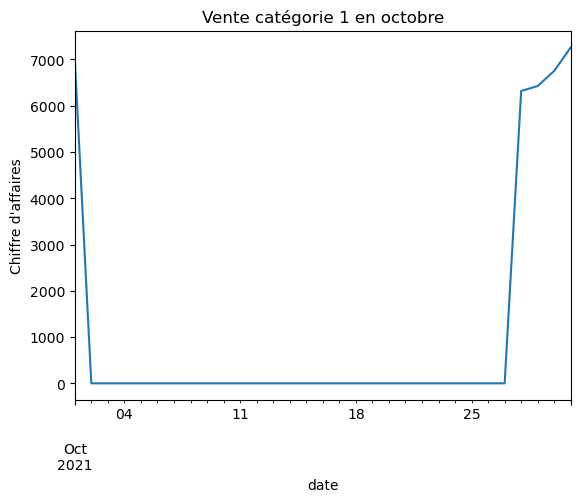

In [297]:
oct_categ_1.plot()
plt.title('Vente catégorie 1 en octobre')
plt.ylabel('''Chiffre d'affaires''')

In [298]:
# Sauvegarde du ratio = Nombre de jours de vente de la catégorie 1 / nombre de jours total

Business_days_c1 = (365 - (oct_categ_1[oct_categ_1 == 0]).count()) / 365
Business_days_c1

0.9287671232876712

Il manque les ventes de la catégorie 1 du 2 au 27 octobre inclus

# Analyse

## Principaux clients

In [299]:
client_CA = data.groupby('client_id')['price'].sum() #regroupement des CA par client
client_CA = client_CA.reset_index().sort_values('price', ascending=False ) # Classement
client_CA['percent_of_CA'] = client_CA['price'] / total_CA # %
client_CA.head(5)
# aucun client ne représente une part importante du CA
# 4 clients ont un volum d'achat supérieur à 500000€ 
# On peut supposer que ces 4 clients sont des entreprises
# il serait intéressant de leur proposer des conditions d'achat particulière

,client_id,price,percent_of_CA
677,c_1609,162007.34,0.027949
4388,c_4958,144257.21,0.024887
6337,c_6714,73197.34,0.012628
2724,c_3454,54442.92,0.009392
7715,c_7959,2564.25,0.000442


In [300]:
# Sauvegarde des 4 premiers client_id du classement dans une liste
list_customer_grossiste = list(client_CA.head(4)['client_id'])

## Catégorie

### Rappel distribution de la table products

Text(0.5, 1.1, 'Prix par catégorie')

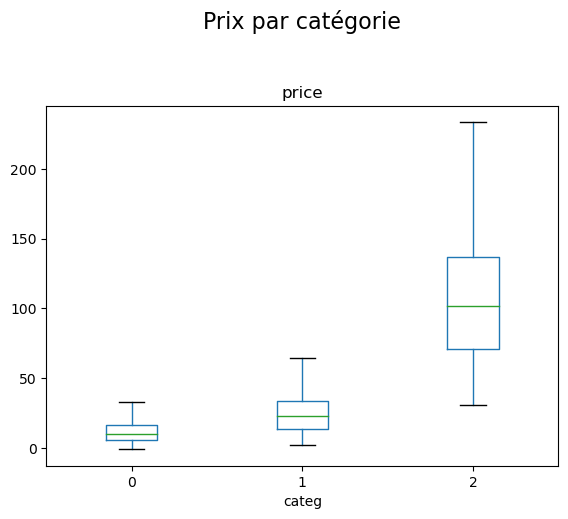

In [301]:
products.boxplot(column='price', by='categ', showfliers=False, grid=False) # boîte à moustache par catégorie
plt.suptitle('Prix par catégorie', size=16, y=1.1)

#fichier déjà enregistré

Text(0.5, 1.1, 'Prix par catégorie')

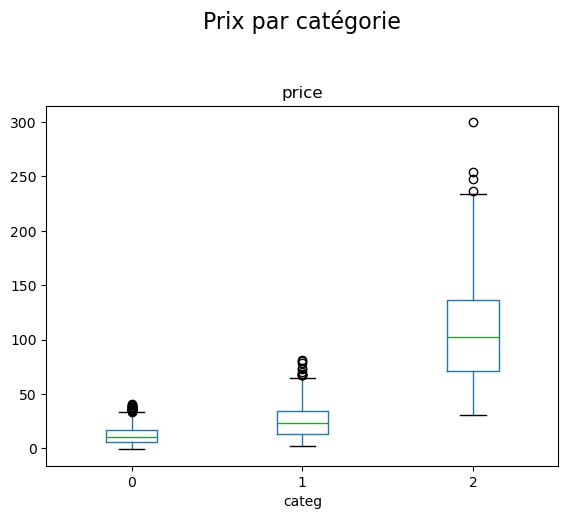

In [302]:
products.boxplot(column='price', by='categ', showfliers=True, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1)

#fichier déjà enregistré

### Distribution des prix par catégorie (produits vendus)

In [303]:
data.groupby('categ')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
categ,,,,,,,,
0,209426.0,10.646828,4.930030,0.62,6.30,9.99,14.45,40.99
1,109735.0,20.480106,7.568956,2.00,15.81,19.08,24.98,80.99
2,17552.0,75.174949,39.079999,30.99,53.99,62.83,71.21,300.00


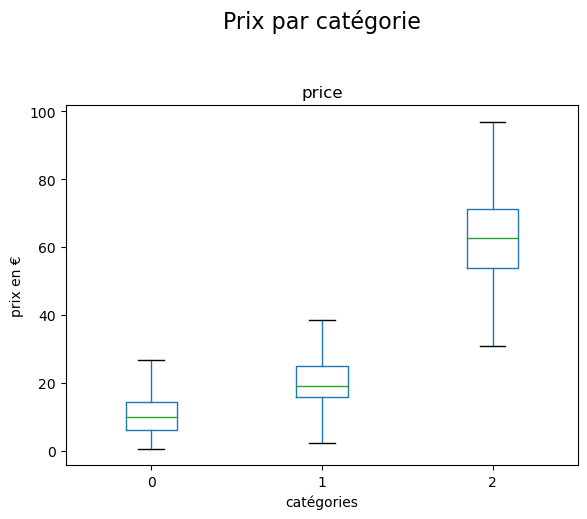

In [304]:
# Boîte à moustache des produits vendus

data.boxplot(column='price', by='categ', showfliers= False, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1);      
plt.ylabel('prix en €')
plt.xlabel('catégories')
plt.savefig('prix_categ_vendu')
plt.show()

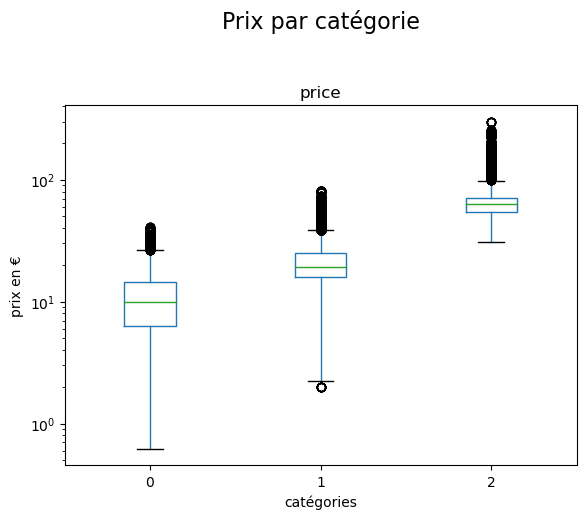

In [305]:
data.boxplot(column='price', by='categ', showfliers= True, grid=False)
plt.suptitle('Prix par catégorie', size=16, y=1.1);  
plt.yscale('log')
plt.ylabel('prix en €')
plt.xlabel('catégories')
plt.savefig('prix_categ_vendu_outlier')
plt.show()

### Distribution des achats par client et par catégorie

In [306]:
client_categ = data.groupby(['categ','client_id'])['price'].sum() # Groupement par client et catégorie
client_categ = client_categ.to_frame()
client_categ

price
categ client_id         
0     c_1         174.20
      c_10        124.92
      c_100        31.38
      c_1000      169.85
      c_1001      527.81
...                  ...
2     c_995         0.00
      c_996         0.00
      c_997       329.11
      c_998      1331.46
      c_999         0.00

[25800 rows x 1 columns]

Text(0.5, 1.0, 'achat par catégorie')

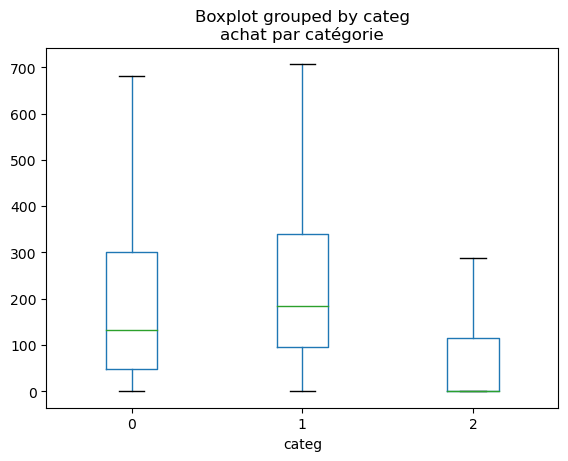

In [307]:
client_categ.boxplot(column='price', by='categ', showfliers=False, grid=False)
plt.title('achat par catégorie')

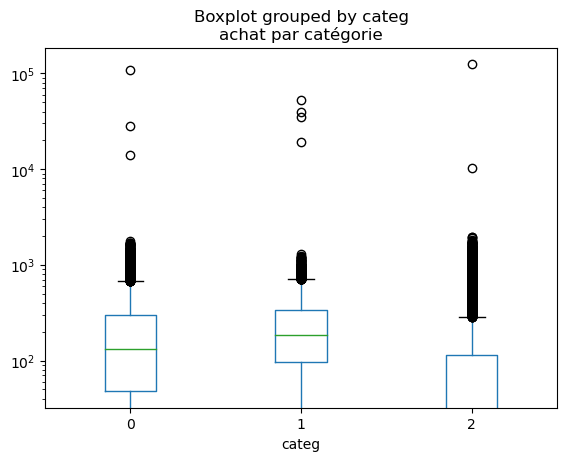

In [308]:
client_categ.boxplot(column='price', by='categ', showfliers=True, grid=False)
plt.title('achat par catégorie')
plt.yscale('log')

----

## Chiffres d'affaires

### Par produit

In [309]:
# groupement et classement
product_CA = data.groupby('id_prod')['price'].sum()
product_CA = product_CA.sort_values(ascending=False)
product_CA

id_prod
2_135     33874.09
2_112     31960.61
2_102     28919.46
2_209     27296.10
2_110     27016.50
            ...   
0_1858        1.83
0_1284        1.38
0_1840        1.28
0_1539        0.99
0_1653        0.99
Name: price, Length: 3264, dtype: float64

### Par catégorie

In [310]:
category_CA = data.groupby('categ')['price'].sum()

In [311]:
category_CA = category_CA.sort_values(ascending=False)

In [312]:
category_CA = category_CA.reset_index()

In [313]:
category_CA

,categ,price
0,1,2247384.41
1,0,2229722.65
2,2,1319470.71


#### Pondération de la catégorie en fonction des données manquantes

In [314]:
Business_days_c1

# = 339/365

0.9287671232876712

In [315]:

## On divise le total de la catégorie 1 par (339/365)

category_CA.loc[category_CA['categ'] == 1, 'price'] = category_CA.loc[category_CA['categ'] == 1, 'price'] / Business_days_c1

In [316]:
category_CA['percentage_of_CA'] = category_CA['price'] / total_CA

In [317]:
category_CA =category_CA.set_index('categ')

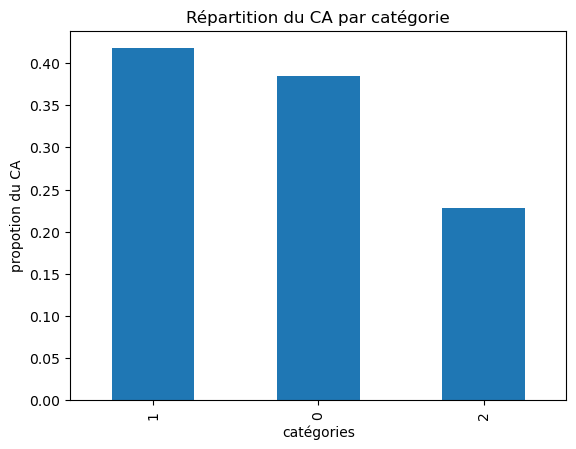

In [318]:
category_CA['percentage_of_CA'].plot(kind='bar')
plt.title('Répartition du CA par catégorie')
plt.xlabel('catégories')
plt.ylabel('propotion du CA')
plt.savefig('repartition_CA_par_categ')
plt.show()

----

## Analyse des indicateurs de tendances centrales

In [319]:
data.describe()
# prix moyen d'un livre 17.21 €
# âge moyen 45 ans des acheteurs

,birth,price
count,336713.000000,336713.000000
mean,1977.823568,17.215189
std,13.524433,17.855445
min,1929.000000,0.620000
25%,1971.000000,8.610000
50%,1980.000000,13.900000
75%,1987.000000,18.990000
max,2004.000000,300.000000


## Panier moyen

In [320]:
session_id_total = data.groupby('session_id')['price'].sum()
session_id_total 

session_id
s_1        11.99
s_10       26.99
s_100      33.72
s_1000     39.22
s_10000    41.49
           ...  
s_99994    28.92
s_99995    19.84
s_99996    56.27
s_99997     6.99
s_99998    35.11
Name: price, Length: 169173, dtype: float64

In [321]:
session_id_total.describe()

count    169173.000000
mean         34.264202
std          31.872538
min           0.620000
25%          15.200000
50%          25.560000
75%          42.980000
max         539.230000
Name: price, dtype: float64

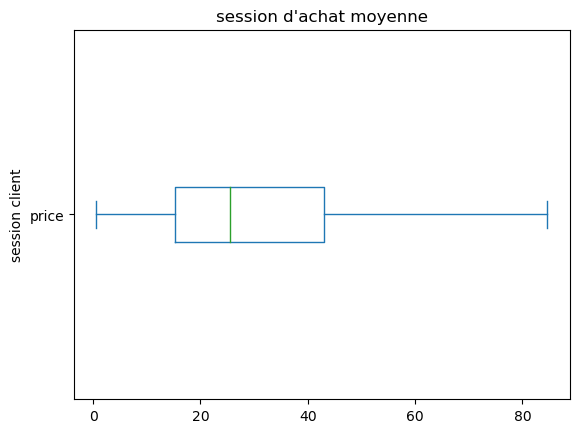

In [322]:
session_id_total.plot(kind='box', vert=False, showfliers=False)
plt.title('''session d'achat moyenne''')
plt.ylabel('session client')
plt.show()

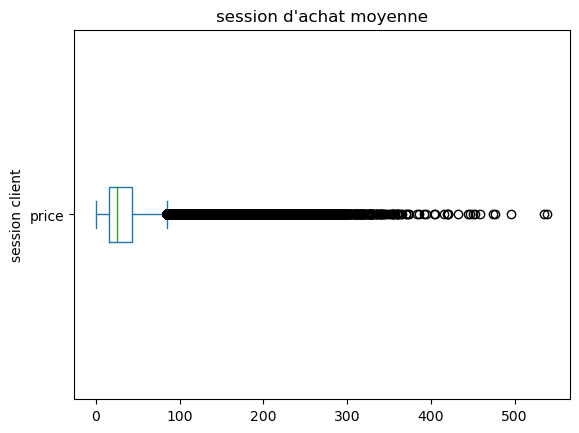

In [323]:
session_id_total.plot(kind='box', vert=False, showfliers=True)
plt.title('''session d'achat moyenne''')
plt.ylabel('session client')
plt.show()

----

### Panier moyen par client

In [324]:
panier_moyen = data.groupby(['client_id','session_id', 'birth'])['price'].sum() #groupement par client 
panier_moyen

client_id  session_id  birth
c_1        s_105105    1955      7.99
           s_114737    1955     92.62
           s_120172    1955     44.29
           s_134971    1955     10.30
           s_136532    1955     13.78
                                ...  
c_999      s_88239     1964     15.99
           s_89648     1964      5.99
           s_92374     1964      8.57
           s_98289     1964     11.99
           s_99070     1964      7.98
Name: price, Length: 169173, dtype: float64

In [325]:
panier_moyen = panier_moyen.to_frame()

In [326]:
panier_moyen = panier_moyen.reset_index()

In [327]:
panier_moyen = panier_moyen.groupby('client_id')['price'].mean() # moyenne des sessions par client

In [328]:
panier_moyen.describe()

count    8600.000000
mean       40.106253
std        22.643521
min         4.150000
25%        25.396925
50%        31.839702
75%        48.329000
max       241.160000
Name: price, dtype: float64

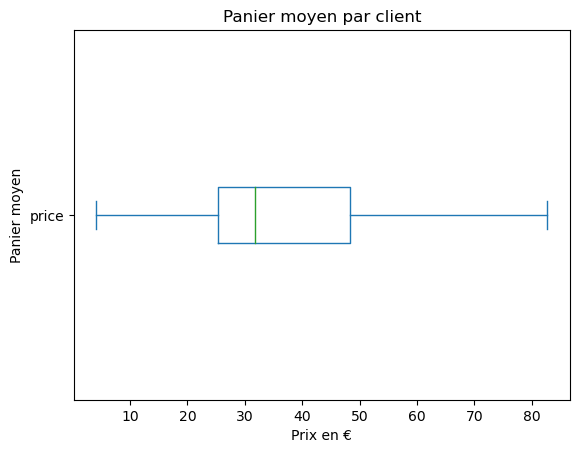

In [329]:
panier_moyen.plot(kind='box', vert=False, showfliers=False)
plt.title('Panier moyen par client')
plt.xlabel('Prix en €')
plt.ylabel('Panier moyen')
plt.savefig('panier_moyen')
plt.show()

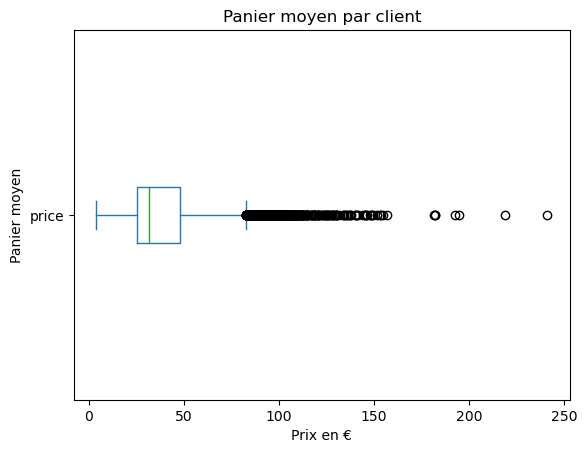

In [330]:
panier_moyen.plot(kind='box', vert=False, showfliers=True)
plt.title('Panier moyen par client')
plt.xlabel('Prix en €')
plt.ylabel('Panier moyen')
plt.savefig('panier_moyen_outliers')
plt.show()

----

# Analyses bivariées

In [331]:
# les groupes ont été défini plus bas dans le notebook mais j'ai décidé de les définir ici.
# Cela me permet de créer 'data_no_2004', 'data_no_grossiste' et 'data_no_2004_grossiste' sur cette base
data.loc[(data['birth'] < 1972), 'groupe'] = 1
data.loc[(data['birth'] > 1971)&(data['birth'] < 1992), 'groupe'] = 2
data.loc[data['birth'] > 1991, 'groupe'] = 3
data['groupe']= data['groupe'].astype('category')


data.loc[data['birth'] < 1992, 'groupe_fre'] = 1
data.loc[data['birth'] > 1991, 'groupe_fre'] = 2
data['groupe_fre']= data['groupe_fre'].astype('category')

## Préparation du dataset 

In [332]:
data_no_2004 = data[data['birth'] != 2004] # sans les clients ayant renseigné une année de naissance égale à 2004
data_no_grossiste = data[~data['client_id'].isin(list_customer_grossiste)] # sans les clients grossistes 
data_no_2004_grossiste = data[(data['birth'] != 2004)&(~data['client_id'].isin(list_customer_grossiste))] # sans les clients ayant renseigné une année de naissance égale à 2004 et sans les clients grossistes

### Analyse par sexe

<Figure size 640x480 with 0 Axes>

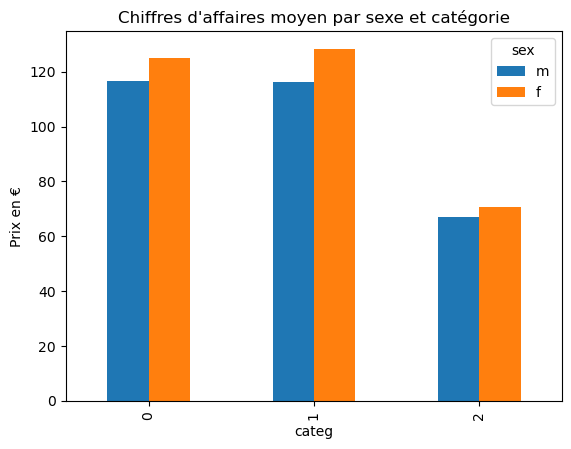

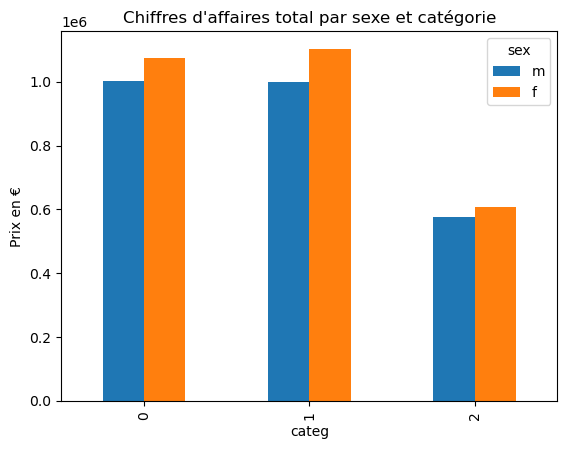

In [333]:
sex_data = data_no_grossiste.groupby([ 'sex', 'categ', 'client_id'])['price'].sum() #groupement par par sex, catégorie et client
sex_data = sex_data.to_frame()
sex_data = sex_data.reset_index()
sex_data_s = sex_data.pivot_table(index='categ', columns='sex', values='price', aggfunc=np.sum)# pivot en effectuant une somme
sex_data_s = sex_data_s[['m','f']] # on inverse les colonnes pour les couleurs
sex_data_m = sex_data.pivot_table(index='categ', columns='sex', values='price', aggfunc=np.mean) # pivot en effectuant une moyenne
sex_data_m = sex_data_m[['m','f']] # on inverse les colonnes pour les couleurs
# Graphique
plt.figure(1)
sex_data_m.plot(kind='bar', colormap=None)
plt.title('''Chiffres d'affaires moyen par sexe et catégorie''')
plt.ylabel('Prix en €')
plt.savefig('CA_s_par_sex')
plt.figure(2)
sex_data_s.plot(kind='bar')
plt.title('''Chiffres d'affaires total par sexe et catégorie''')
plt.ylabel('Prix en €')
plt.savefig('CA_m_par_sex')
plt.show()

----

## Corrélation entre le sexe et la catégorie : Chi deux

### Méthode 1 : avec scipy

In [334]:
from scipy.stats import chi2_contingency

In [335]:
sex_categ = data_no_grossiste.groupby(['sex','categ'])['client_id'].count()

# le .count() va compter les doublons. On va donc comptabiliser si un client à acheter plusieurs fois des produits dans une catégorie

In [336]:
# création du tableau de contingence
sex_categ_f = sex_categ['f'].to_numpy()
sex_categ_m = sex_categ['m'].to_numpy()
sex_categ_con = np.row_stack((sex_categ_f, sex_categ_m))
sex_categ_con

array([[101148,  53774,   8122],
       [ 94023,  48851,   7634]])

In [337]:
# Résultats du test
chi2, pvalue, degrees, expected = chi2_contingency(sex_categ_con)
chi2, degrees, pvalue

(10.202417277273174, 2, 0.0060893822533516695)

In [338]:
chi2_contingency(sex_categ_con)

(10.202417277273174,
 0.0060893822533516695,
 2,
 array([[101487.02774659,  53364.00501352,   8192.96723988],
        [ 93683.97225341,  49260.99498648,   7563.03276012]]))

In [339]:
# Valeur critique pour alpha à 0.05 et degrés de liberté à 2
stats.chi2.ppf(q=1-0.05, df=2)

5.991464547107979

### Méthode 2 : avec numpy

In [340]:
# Calcul des totaux
N = sex_categ_con.sum()
ni = sex_categ_con.sum(axis=1)
nj = sex_categ_con.sum(axis=0)
ni, nj, N

(array([163044, 150508]), array([195171, 102625,  15756]), 313552)

In [341]:
# On applique la formule
nij = ni.reshape(sex_categ_con.shape[0], 1) * nj / N
nij

array([[101487.02774659,  53364.00501352,   8192.96723988],
       [ 93683.97225341,  49260.99498648,   7563.03276012]])

In [342]:
# Calcul du chi²
d = (sex_categ_con - nij) ** 2 / nij
d.sum()

10.202417277273174

In [343]:
# Création d'un tableau de contingence des valeurs théoriques
contingence_t = pd.DataFrame(data=nij, index=None, columns=['categ_1', 'categ_2', 'categ_3'])
contingence_t['total'] = contingence_t['categ_1'] + contingence_t['categ_2'] + contingence_t['categ_3'] 
contingence_t = contingence_t.append({'categ_1' : contingence_t['categ_1'].sum(), 'categ_2' : contingence_t['categ_2'].sum(), 'categ_3' : contingence_t['categ_3'].sum(), 'total' : contingence_t['total'].sum()}, ignore_index=True)
contingence_t['sex'] = ['homme','femme','total']
contingence_t.set_index('sex', inplace=True)
contingence_t.head()

/tmp/ipykernel_107731/1373334587.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contingence_t = contingence_t.append({'categ_1' : contingence_t['categ_1'].sum(), 'categ_2' : contingence_t['categ_2'].sum(), 'categ_3' : contingence_t['categ_3'].sum(), 'total' : contingence_t['total'].sum()}, ignore_index=True)


,categ_1,categ_2,categ_3,total
sex,,,,
homme,101487.027747,53364.005014,8192.96724,163044.0
femme,93683.972253,49260.994986,7563.03276,150508.0
total,195171.000000,102625.000000,15756.00000,313552.0


In [344]:
# Création d'un tableau de contingence des valeurs observées
contingence_o = pd.DataFrame(data=sex_categ_con, index=None, columns=['categ_0', 'categ_1', 'categ_2'])
contingence_o['total'] = contingence_o['categ_0'] + contingence_o['categ_1'] + contingence_o['categ_2'] 
contingence_o = contingence_o.append({'categ_0' : contingence_o['categ_0'].sum(), 'categ_1' : contingence_o['categ_1'].sum(), 'categ_2' : contingence_o['categ_2'].sum(), 'total' : contingence_o['total'].sum()}, ignore_index=True)
contingence_o['sex'] = ['homme','femme','total']
contingence_o.set_index('sex', inplace=True)
contingence_o.head()

/tmp/ipykernel_107731/2520331246.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contingence_o = contingence_o.append({'categ_0' : contingence_o['categ_0'].sum(), 'categ_1' : contingence_o['categ_1'].sum(), 'categ_2' : contingence_o['categ_2'].sum(), 'total' : contingence_o['total'].sum()}, ignore_index=True)


,categ_0,categ_1,categ_2,total
sex,,,,
homme,101148,53774,8122,163044
femme,94023,48851,7634,150508
total,195171,102625,15756,313552


In [345]:
# Création d'un tableau de contingence des contributions
contingence_c = pd.DataFrame(data=d, index=None, columns=['categ_0', 'categ_1', 'categ_2'])
contingence_c['total'] = contingence_c['categ_0'] + contingence_c['categ_1'] + contingence_c['categ_2'] 
contingence_c = contingence_c.append({'categ_0' : contingence_c['categ_0'].sum(), 'categ_1' : contingence_c['categ_1'].sum(), 'categ_2' : contingence_c['categ_2'].sum(), 'total' : contingence_c['total'].sum()}, ignore_index=True)
contingence_c['sex'] = ['homme','femme','total']
contingence_c.set_index('sex', inplace=True)
contingence_c.head()

/tmp/ipykernel_107731/2578016317.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contingence_c = contingence_c.append({'categ_0' : contingence_c['categ_0'].sum(), 'categ_1' : contingence_c['categ_1'].sum(), 'categ_2' : contingence_c['categ_2'].sum(), 'total' : contingence_c['total'].sum()}, ignore_index=True)


,categ_0,categ_1,categ_2,total
sex,,,,
homme,1.132557,3.149986,0.614716,4.897259
femme,1.226889,3.412353,0.665917,5.305158
total,2.359445,6.562339,1.280633,10.202417


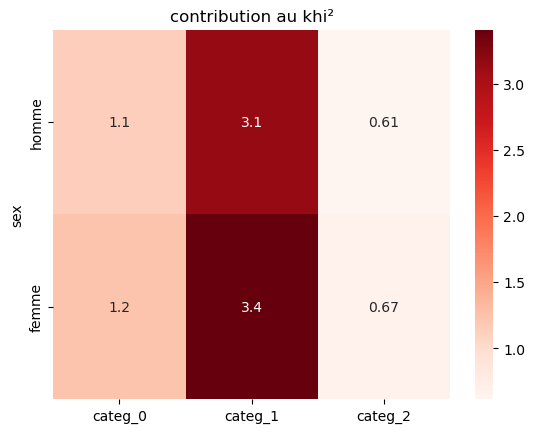

In [346]:
# Création d'un tableau de contingence des contributions avec heatmap
sns.heatmap(contingence_c.iloc[0:2,0:3], annot=True,cmap='Reds')
plt.title('contribution au khi²')
plt.savefig('contri_chi')

### Analyse du résultat

Nous pouvons affirmer avec 0.1% de marge d'erreur que les variables ne sont pas indépendantes

Il y a une corrélation entre le sexe et la catégorie

Le plus important contibuteur est la catégorie 1 (voir d)

----

## Âge et montant des achats

In [347]:
# Groupement par client
age_price = data_no_2004_grossiste.groupby(['birth', 'client_id', 'groupe'], observed=True)['price'].sum().to_frame()
age_price.reset_index(inplace=True)
age_price

,birth,client_id,groupe,price
0,1929,c_5302,1.0,269.94
1,1929,c_577,1.0,761.14
2,1929,c_8362,1.0,268.95
3,1930,c_3218,1.0,37.27
4,1930,c_353,1.0,504.21
...,...,...,...,...
8154,2003,c_8413,3.0,662.78
8155,2003,c_8429,3.0,492.99
8156,2003,c_8531,3.0,27.18
8157,2003,c_8567,3.0,707.70


In [348]:
# Moyenne des montants des achats des clients par âge
age_price = age_price.groupby(['birth', 'groupe'], observed=True)['price'].mean().to_frame()
age_price.reset_index(inplace=True)

In [349]:
# Calcul des paramètres
a,b,r,p,z = stats.linregress(age_price.birth, age_price.price)
a,b,r,p,z
# corrélation forte

(5.215528245300417,
 -9696.550116451315,
 0.7488621999425011,
 1.1151519039521786e-14,
 0.5402176887542073)

In [350]:
# calcul du coefficient de détermination
age_price_r2= r**2
age_price_r2
# coefficient de détermination proche de 1, pouvoir de prédiction fort

0.5607945945027225

/home/jeremy/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


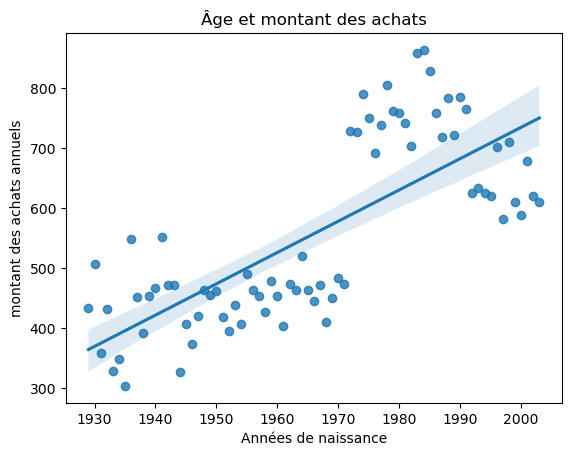

In [351]:
# Représentation graphique avec seaborn
sns.regplot(age_price.birth,age_price.price)
plt.title('Âge et montant des achats')
plt.xlabel('Années de naissance')
plt.ylabel('montant des achats annuels')
plt.savefig('age_achat')

<Figure size 640x480 with 0 Axes>

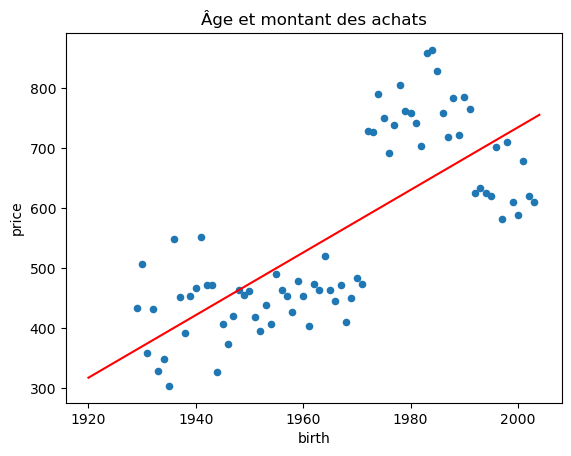

In [352]:
# Représentation graphique classique avec matplotlib
x = np.arange(1920,2005,1)
plt.figure(1)
age_price.plot('birth', 'price', kind='scatter')
plt.title('Âge et montant des achats')
plt.figure(2)
plt.plot(x, a*x+b, 'red')
plt.show()

### Âge et montant des achats : identification des groupes

#### Recherche de ruptures

In [353]:
age_price[(age_price['birth'] > 1965)&(age_price['birth'] < 1975)]
# entre 1971 et 1972

,birth,groupe,price
37,1966,1.0,445.097500
38,1967,1.0,472.099863
39,1968,1.0,409.530333
40,1969,1.0,449.757660
41,1970,1.0,482.750494
42,1971,1.0,473.999193
43,1972,2.0,729.237305
44,1973,2.0,726.927417
45,1974,2.0,790.321875


In [354]:
age_price[(age_price['birth'] > 1985)&(age_price['birth'] < 1995)]
# entre 1991 et 1992

,birth,groupe,price
57,1986,2.0,758.998621
58,1987,2.0,719.040227
59,1988,2.0,782.684928
60,1989,2.0,721.754797
61,1990,2.0,784.313716
62,1991,2.0,764.422759
63,1992,3.0,624.411398
64,1993,3.0,633.449485
65,1994,3.0,624.636667


Description de la population


,birth,price
count,75.000000,75.000000
mean,1966.000000,557.178414
std,21.794495,151.790013
min,1929.000000,303.545000
25%,1947.500000,447.427580
50%,1966.000000,482.750494
75%,1984.500000,706.758042
max,2003.000000,863.545419


Coefficient de variation = 0.27242622627588287

Paramètre du groupe 1
a = 1.24924747754241
b = -1996.3968606471592
r = 0.28846514412462027
p = 0.060662125434670866
z = 0.6475862753938342
CV = 0.1236892933987255
r² = 0.08321213937483794

             birth       price
count    43.000000   43.000000
mean   1950.000000  439.635721
std      12.556539   54.378232
min    1929.000000  303.545000
25%    1939.500000  407.872326
50%    1950.000000  452.653636
75%    1960.500000  471.455875
max    1971.000000  552.338571


/home/jeremy/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


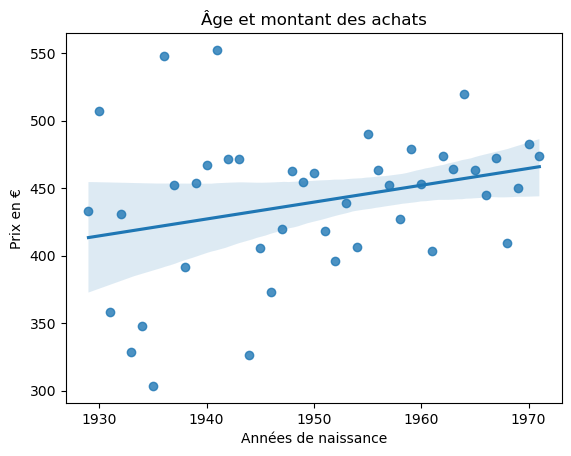


Paramètre du groupe 2
a = 1.8428101386722024
b = -2887.615795678931
r = 0.22995552544274767
p = 0.32939685716733247
z = 1.8382437557573446
CV = 0.06206219800897118
r² = 0.05287954368165017



/home/jeremy/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


            birth       price
count    20.00000   20.000000
mean   1981.50000  763.912494
std       5.91608   47.410088
min    1972.00000  692.491429
25%    1976.75000  728.659833
50%    1981.50000  758.561152
75%    1986.25000  785.815756
max    1991.00000  863.545419


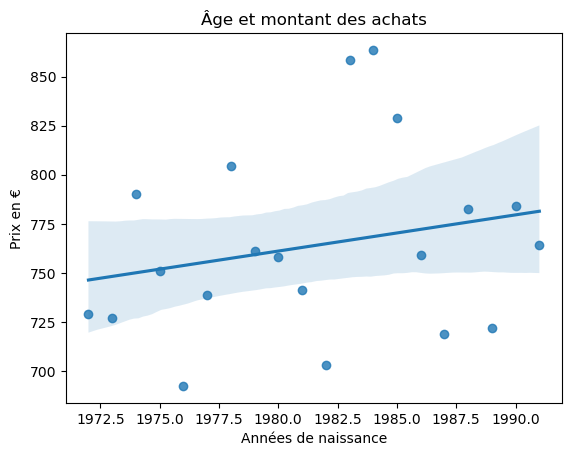


Paramètre du groupe 3
a = -0.6868040822179142
b = 2005.7074183630984
r = -0.06003529287090063
p = 0.8529645987158349
z = 3.611122077624885
CV = 0.06507804998220924
r² = 0.0036042363900948126

             birth       price
count    12.000000   12.000000
mean   1997.500000  633.816264
std       3.605551   41.247527
min    1992.000000  582.475430
25%    1994.750000  610.661030
50%    1997.500000  622.376727
75%    2000.250000  644.850074
max    2003.000000  710.472263


/home/jeremy/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


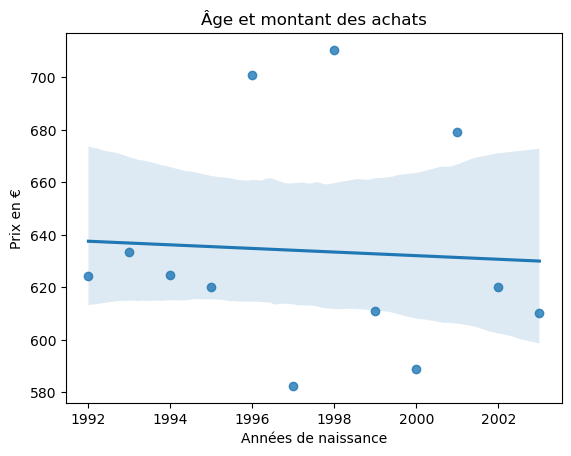

In [355]:
# Definition des variables

a_pm_g1 = age_price[(age_price['birth'] < 1972)]
a_pm_g2 = age_price[(age_price['birth'] > 1971)&(age_price['birth'] < 1992)]
a_pm_g3 = age_price[age_price['birth'] > 1991]
bornes = [1920,1973,1993,2004]
a_pm_g =[a_pm_g1, a_pm_g2, a_pm_g3] # Création d'une liste pour pourvoir itérer
i=0 #compteur

print('Description de la population')
display(age_price.describe()) # paramètres généraux

CV = age_price.describe().loc['std','price'] / age_price.describe().loc['mean','price'] # Coefficient de variation général
print('Coefficient de variation = ' +  str(CV))

# Création de la boucle

for group in a_pm_g :
    a,b,r,p,z = stats.linregress(a_pm_g[i].birth, a_pm_g[i].price) # Paramètre par groupe
    CV = a_pm_g[i].describe().loc['std','price'] / a_pm_g[i].describe().loc['mean','price'] # CV par groupe
    print('\n'+ 'Paramètre du groupe ' + str(i+1) +'\n'+ 'a = ' + str(a) + '\n'+ 'b = ' + str(b) + '\n' + 'r = ' + str(r) + '\n' + 'p = ' + str(p) + '\n' + 'z = ' + str(z) + '\n' + 'CV = ' + str(CV))
    age_price_r2 = r**2 # Coefficient de détermination
    print('r² = ' + str (age_price_r2) + '\n')
    print(a_pm_g[i].describe())
    sns.regplot(a_pm_g[i].birth,a_pm_g[i].price) # Graphique
    plt.title('Âge et montant des achats')
    plt.xlabel('Années de naissance')
    plt.ylabel('Prix en €')
    plt.savefig('age_achat'+ str(i))
    plt.show()
    i+=1 # incrémentation

### Boîte à moustache

Text(0.5, 0.98, '')

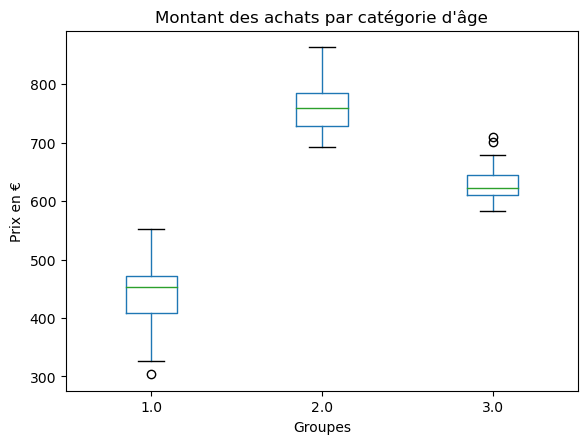

In [356]:
age_price.boxplot('price', by='groupe', grid=False)
plt.title( '''Montant des achats par catégorie d'âge''' )
plt.ylabel('Prix en €')
plt.xlabel('Groupes')
plt.savefig('boxplot_age_montante')
plt.suptitle('') 

### ANOVA

In [357]:
#Calcul des paramètres
statf, pvalue = stats.f_oneway(age_price['price'][age_price['groupe'] == 1], age_price['price'][age_price['groupe'] == 2], age_price['price'][age_price['groupe'] == 3])
statf, pvalue

(294.67930982983046, 2.1293017773343167e-35)

In [358]:
# Deuxième méthode comprennant plus de détails
import statsmodels.api as sm
from statsmodels.formula.api import ols # import d'un module pour réaliser une analyse post-hoc
model = ols('price ~ C(groupe)', data=age_price).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq    df          F        PR(>F)
C(groupe)  1.519360e+06   2.0  294.67931  2.129302e-35
Residual   1.856152e+05  72.0        NaN           NaN


In [359]:
# Calcul de la valeur critique pour des degrés de liberté de 2 et 72
stats.f.ppf(q=1-0.05, dfn=2, dfd=72)
# Notre valeur F est largement au-dessus de la valeur critique

3.1239074485457783

#### Analyse Post-hoc

In [360]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# On effectue une analyse par paires
m_comp = pairwise_tukeyhsd(endog=age_price['price'], groups=age_price['groupe'], alpha=0.05)
print(m_comp)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2  meandiff p-adj   lower    upper   reject
-------------------------------------------------------
   1.0    2.0  324.2768  -0.0  291.3896  357.164   True
   1.0    3.0  194.1805  -0.0  154.5105 233.8505   True
   2.0    3.0 -130.0962   0.0 -174.4648 -85.7277   True
-------------------------------------------------------


Toutes les paires rejettent l'hypothèse nulle

----

## Âge et fréquence des achats

In [361]:
# On sélectionne les colonnes utiles et on supprime les doublons (en particulier les doublons dans les session_id)
age_frequence = data_no_2004_grossiste[['birth', 'client_id', 'groupe_fre', 'session_id']].drop_duplicates()
age_frequence = age_frequence.groupby([ 'birth', 'client_id', 'groupe_fre'], observed=True)['session_id'].count().to_frame().reset_index()

In [362]:
# On effectue la moyenne du nombre de sessions par âge
age_frequence = age_frequence.groupby(['groupe_fre', 'birth'], observed=True)['session_id'].mean().to_frame().reset_index()

In [363]:
age_frequence

,groupe_fre,birth,session_id
0,1.0,1929,21.333333
1,1.0,1930,18.000000
2,1.0,1931,12.250000
3,1.0,1932,17.166667
4,1.0,1933,14.625000
...,...,...,...
70,2.0,1999,8.607595
71,2.0,2000,8.676471
72,2.0,2001,9.384000
73,2.0,2002,8.800000


In [364]:
# Paramètres
a,b,r,p,z = stats.linregress(age_frequence.birth, age_frequence.session_id)
a,b,r,p,z
# corrélation modérée

(-0.0346923678724417,
 86.57190123407655,
 -0.14458393262204997,
 0.21585782298955508,
 0.027788493561009164)

In [365]:
# Coefficient de détermination
age_frequence_r2= r**2
age_frequence_r2
# R² proche de 0, pouvoir de prédiction faible

0.020904513572457484

<Figure size 640x480 with 0 Axes>

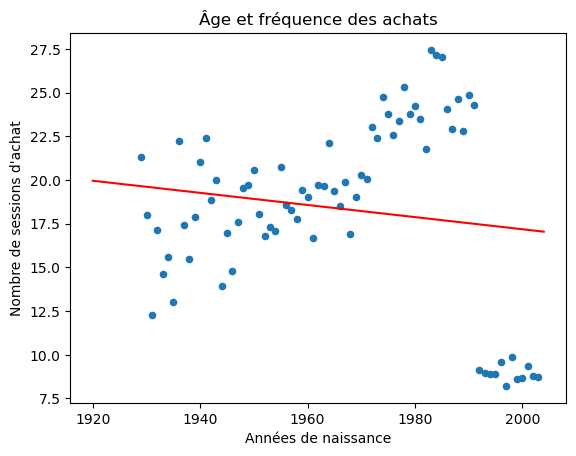

In [366]:
x = np.arange(1920,2005,1)
plt.figure(1)
age_frequence.plot('birth', 'session_id', kind='scatter')
plt.title('Âge et fréquence des achats')
plt.figure(2)
plt.plot(x, a*x+b, 'red')
plt.xlabel('Années de naissance')
plt.ylabel('''Nombre de sessions d'achat''')
plt.savefig('age_frequence')
plt.show()

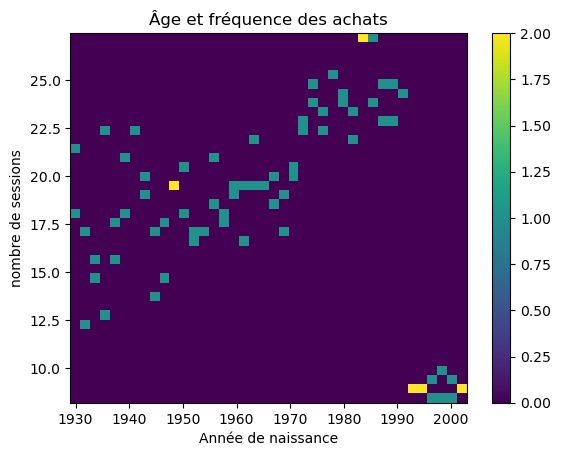

In [367]:
# Représentation avec un hidtogramme en 2d
plt.hist2d(age_frequence.birth, age_frequence.session_id, bins=40)
plt.title('Âge et fréquence des achats')
plt.xlabel('Année de naissance')
plt.ylabel('nombre de sessions')
plt.colorbar()

### Âge et fréquence des achats : identification des groupes

#### Recherche de ruptures

Graphiquement on identifie 2 groupes

In [368]:
age_frequence[(age_frequence['birth'] > 1985)&(age_frequence['birth'] < 1995)]

# avant 1992 et après

,groupe_fre,birth,session_id
57,1.0,1986,24.064039
58,1.0,1987,22.897727
59,1.0,1988,24.623188
60,1.0,1989,22.783784
61,1.0,1990,24.871622
62,1.0,1991,24.275862
63,2.0,1992,9.155914
64,2.0,1993,8.933824
65,2.0,1994,8.884615


#### Analyse par groupe

Description de la population


,birth,session_id
count,75.000000,75.000000
mean,1966.000000,18.366706
std,21.794495,5.229507
min,1929.000000,8.218543
25%,1947.500000,16.151955
50%,1966.000000,19.049645
75%,1984.500000,22.395104
max,2003.000000,27.450617


Coefficient de variation = 0.2847275167415812

Paramètre du groupe 1
a = 0.14436528990909436
b = -262.8011244019916
r = 0.7546277401377479
p = 9.162467520323563e-13
z = 0.01607201506901927
CV = 0.1739883714296003
r² = 0.5694630261854043

             birth  session_id
count    63.000000   63.000000
mean   1960.000000   20.154844
std      18.330303    3.506708
min    1929.000000   12.250000
25%    1944.500000   17.692130
50%    1960.000000   19.710280
75%    1975.500000   22.840756
max    1991.000000   27.450617


/home/jeremy/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


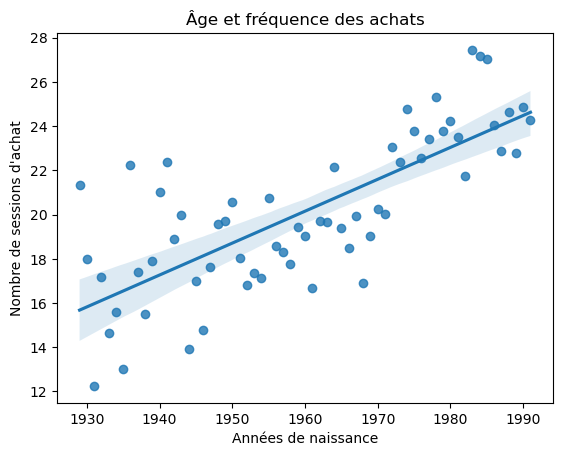


Paramètre du groupe 2
a = -0.016635267965292827
b = 42.20793018689849
r = -0.1303878317295772
p = 0.6862869189164857
z = 0.040000855400084155
CV = 0.0512315260167141
r² = 0.01700098666314054

             birth  session_id
count    12.000000   12.000000
mean   1997.500000    8.978982
std       3.605551    0.460007
min    1992.000000    8.218543
25%    1994.750000    8.712221
50%    1997.500000    8.882308
75%    2000.250000    9.212935
max    2003.000000    9.890511


/home/jeremy/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


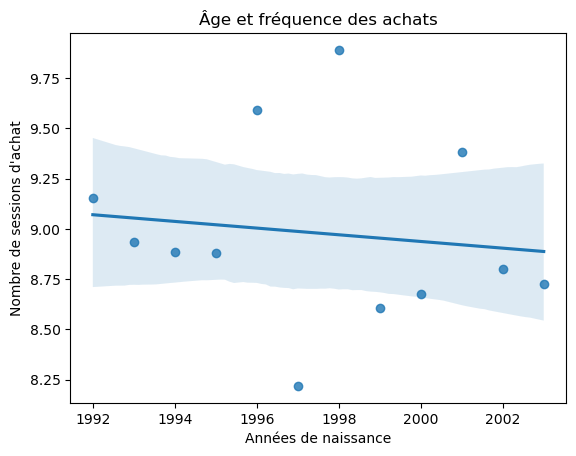

In [369]:
# Definition des variables

a_pm_g1 = age_frequence[(age_frequence['birth'] < 1992)]
a_pm_g2 = age_frequence[(age_frequence['birth'] > 1991)]
bornes = [1920,1993,2004]
a_pm_g =[a_pm_g1, a_pm_g2] # Création d'une liste pour pourvoir itérer
i=0 #compteur

print('Description de la population')
display(age_frequence.describe())  # paramètres généraux

CV = age_frequence.describe().loc['std','session_id'] / age_frequence.describe().loc['mean','session_id']
print('Coefficient de variation = ' +  str(CV))

# boucle

for group in a_pm_g :
    a,b,r,p,z = stats.linregress(a_pm_g[i].birth, a_pm_g[i].session_id) # Paramètre par groupe
    CV = a_pm_g[i].describe().loc['std','session_id'] / a_pm_g[i].describe().loc['mean','session_id'] # CV par groupe
    print('\n'+ 'Paramètre du groupe ' + str(i+1) +'\n'+ 'a = ' + str(a) + '\n'+ 'b = ' + str(b) + '\n' + 'r = ' + str(r) + '\n' + 'p = ' + str(p) + '\n' + 'z = ' + str(z) +'\n'+ 'CV = ' + str(CV))
    age_frequence_r2 = r**2
    print('r² = ' + str (age_frequence_r2) + '\n')
    print(a_pm_g[i].describe())
    sns.regplot(a_pm_g[i].birth,a_pm_g[i].session_id) # Graphique
    plt.title('Âge et fréquence des achats')
    plt.xlabel('Années de naissance')
    plt.ylabel('''Nombre de sessions d'achat''')
    plt.savefig('age_fre'+ str(i))
    plt.show()
    i+=1 # incrémentation

### Boîte à moustache

Text(0.5, 0.98, '')

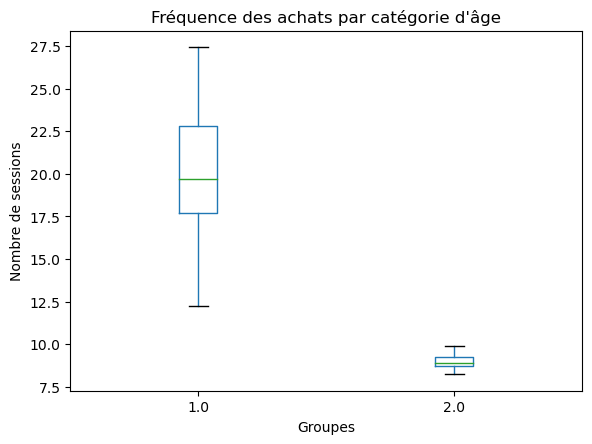

In [370]:
age_frequence.boxplot('session_id', by='groupe_fre', grid=False)
plt.title( '''Fréquence des achats par catégorie d'âge''' )
plt.ylabel('Nombre de sessions')
plt.xlabel('Groupes')
plt.suptitle('') 

### ANOVA

In [371]:
# Calcul des paramètres
model = ols('session_id ~ C(groupe_fre)', data=age_frequence).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                    sum_sq    df           F        PR(>F)
C(groupe_fre)  1258.990769   1.0  120.179531  4.386416e-17
Residual        764.741929  73.0         NaN           NaN


In [372]:
# Calcul de la valeur critique pour des degrés de liberté de 1 et 73
stats.f.ppf(q=1-0.05, dfn=1, dfd=73)

# Notre valeur F est largement au-dessus de la valeur critique

3.9720375438052242

----

# Âge et le panier moyen

In [373]:
# On compte le nombre d'articles par client et session
age_panier_moyen = data_no_2004_grossiste.groupby(['birth','session_id','client_id','groupe'], observed=True)['id_prod'].count().to_frame().reset_index()
age_panier_moyen

,birth,session_id,client_id,groupe,id_prod
0,1929,s_103958,c_577,1.0,1
1,1929,s_111117,c_577,1.0,1
2,1929,s_11322,c_8362,1.0,1
3,1929,s_114374,c_577,1.0,1
4,1929,s_123651,c_5302,1.0,1
...,...,...,...,...,...
153602,2003,s_99083,c_4994,3.0,1
153603,2003,s_99376,c_2228,3.0,1
153604,2003,s_9946,c_7780,3.0,3
153605,2003,s_99521,c_5946,3.0,1


In [374]:
# Panier moyen par client
age_panier_moyen = age_panier_moyen.groupby(['client_id', 'birth', 'groupe'], observed=True)['id_prod'].mean().to_frame().reset_index()
age_panier_moyen

,client_id,birth,groupe,id_prod
0,c_1,1955,1.0,1.333333
1,c_10,1956,1.0,1.750000
2,c_100,1992,3.0,2.000000
3,c_1000,1966,1.0,1.333333
4,c_1001,1982,2.0,2.416667
...,...,...,...,...
8154,c_995,1955,1.0,1.600000
8155,c_996,1970,1.0,1.166667
8156,c_997,1994,3.0,2.300000
8157,c_998,2001,3.0,2.153846


In [375]:
# moyenne des paniers moyens par âge
age_panier_moyen = age_panier_moyen.groupby(['birth', 'groupe'], observed=True)['id_prod'].mean().to_frame().reset_index()
age_panier_moyen

,birth,groupe,id_prod
0,1929,1.0,1.410714
1,1930,1.0,1.282292
2,1931,1.0,1.811972
3,1932,1.0,1.704441
4,1933,1.0,1.663179
...,...,...,...
70,1999,3.0,1.834805
71,2000,3.0,1.941878
72,2001,3.0,1.778739
73,2002,3.0,1.771001


In [376]:
age_panier_moyen.describe()

,birth,id_prod
count,75.000000,75.000000
mean,1966.000000,1.848349
std,21.794495,0.390410
min,1929.000000,1.282292
25%,1947.500000,1.552828
50%,1966.000000,1.692474
75%,1984.500000,2.395809
max,2003.000000,2.550159


In [377]:
# Calcul des paramètres
a,b,r,p,z = stats.linregress(age_panier_moyen.birth, age_panier_moyen.id_prod)
a,b,r,p,z 
# la corrélation est modérée

(0.010422343606513269,
 -18.641978484100925,
 0.5818234963405609,
 4.387518035004216e-08,
 0.0017051850872697267)

In [378]:
# Calcul du coefficient de variation
age_panier_moyen_r2 = r**2
age_panier_moyen_r2
# pouvoir de prédiction faible

0.33851858089395465

<Figure size 640x480 with 0 Axes>

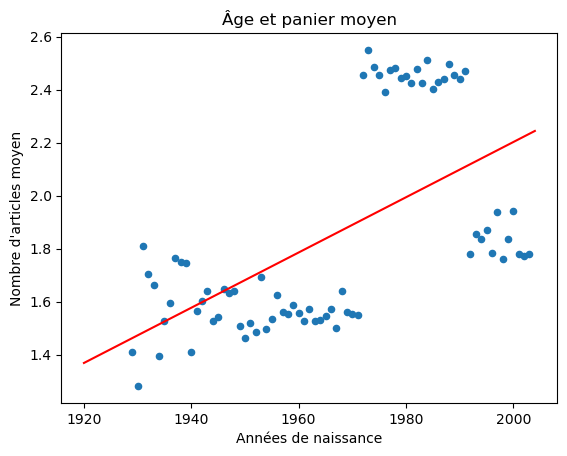

In [379]:
x = np.arange(1920,2005,1)
plt.figure(1)
age_panier_moyen.plot('birth', 'id_prod', kind='scatter')
plt.title('Âge et panier moyen')
plt.figure(2)
plt.plot(x, a*x+b, 'red')
plt.xlabel('Années de naissance')
plt.ylabel('''Nombre d'articles moyen''')
plt.savefig('age_panier_moyen')
plt.show()

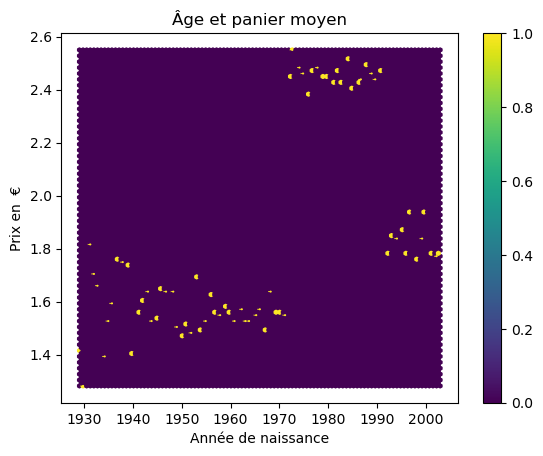

In [380]:
# Représentaiton graphique avec des hexagones de densité
plt.hexbin(age_panier_moyen.birth, age_panier_moyen.id_prod)
plt.title('Âge et panier moyen')
plt.xlabel('Année de naissance')
plt.ylabel('Prix en  €')
plt.colorbar()

### Âge et panier moyen : identification des groupes

Sur ces graphiques on peut indentifier 3 groupes distincts

#### Recherche de ruptures

In [381]:
age_panier_moyen[(age_panier_moyen['birth'] > 1965)&(age_panier_moyen['birth'] < 1975)]
# Ecart significatif entre 1971 et 1972

,birth,groupe,id_prod
37,1966,1.0,1.572089
38,1967,1.0,1.499168
39,1968,1.0,1.640540
40,1969,1.0,1.563033
41,1970,1.0,1.555350
42,1971,1.0,1.551485
43,1972,2.0,2.454408
44,1973,2.0,2.550159
45,1974,2.0,2.484291


In [382]:
age_panier_moyen[(age_panier_moyen['birth'] > 1985)&(age_panier_moyen['birth'] < 1995)]
# Ecart significatif entre 1991 et 1992

,birth,groupe,id_prod
57,1986,2.0,2.429677
58,1987,2.0,2.441891
59,1988,2.0,2.495416
60,1989,2.0,2.455372
61,1990,2.0,2.440754
62,1991,2.0,2.471158
63,1992,3.0,1.781249
64,1993,3.0,1.854039
65,1994,3.0,1.837642


#### Analyse par groupe

Définition de 3 groupes :
- a_pm_g1 : Clients nés avant 1972 (50 ans en 2022)
- a_pm_g2 : Clients nés entre 1972 et 1992 (entre 50 et 30 ans en 2022)
- a_pm_g3 : Clients nés après 1992 (30 ans et en-dessous)

Description de la population


,birth,id_prod
count,75.000000,75.000000
mean,1966.000000,1.848349
std,21.794495,0.390410
min,1929.000000,1.282292
25%,1947.500000,1.552828
50%,1966.000000,1.692474
75%,1984.500000,2.395809
max,2003.000000,2.550159


Coefficient de variation = 0.2112209289205875


Paramètre du groupe 1
a = -0.0007569116820913224
b = 3.0463852014815958
r = -0.0925496149114772
p = 0.5550067372774038
z = 0.001271776197599245
CV = 0.0653925384072132

             birth    id_prod
count    43.000000  43.000000
mean   1950.000000   1.570407
std      12.556539   0.102693
min    1929.000000   1.282292
25%    1939.500000   1.527958
50%    1950.000000   1.556654
75%    1960.500000   1.636906
max    1971.000000   1.811972
r² = 0.008565431220262723



<Figure size 640x480 with 0 Axes>

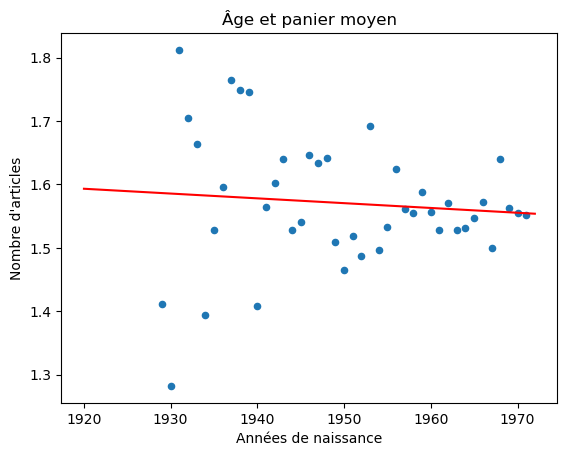


Paramètre du groupe 2
a = -0.0011638532512829299
b = 4.76437624672016
r = -0.18409873239581712
p = 0.43717153259239605
z = 0.0014646165436600232
CV = 0.015214723068724257

            birth    id_prod
count    20.00000  20.000000
mean   1981.50000   2.458201
std       5.91608   0.037401
min    1972.00000   2.390019
25%    1976.75000   2.437985
50%    1981.50000   2.454890
75%    1986.25000   2.479628
max    1991.00000   2.550159
r² = 0.03389234326974668



<Figure size 640x480 with 0 Axes>

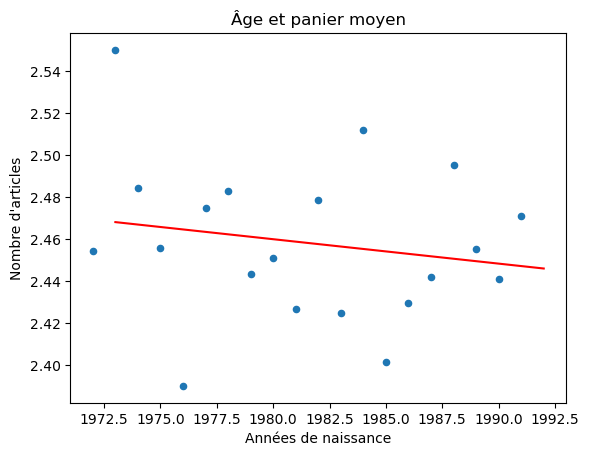


Paramètre du groupe 3
a = -0.0028777969236058964
b = 7.576285918769466
r = -0.16342009923927728
p = 0.6118139245535014
z = 0.005493848365830968
CV = 0.03473578433749123

             birth    id_prod
count    12.000000  12.000000
mean   1997.500000   1.827887
std       3.605551   0.063493
min    1992.000000   1.761855
25%    1994.750000   1.780621
50%    1997.500000   1.808552
75%    2000.250000   1.858331
max    2003.000000   1.941878
r² = 0.026706128835375233



<Figure size 640x480 with 0 Axes>

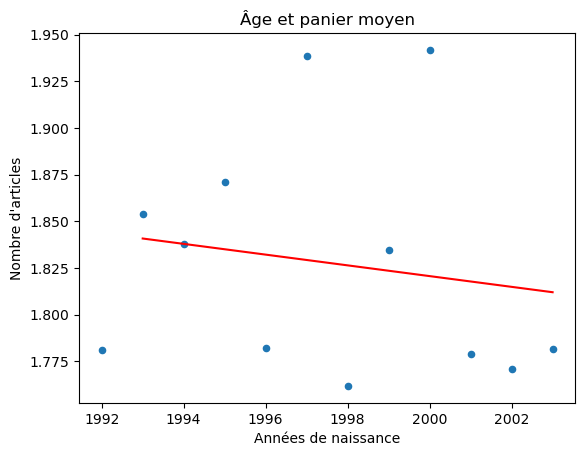

In [383]:
# Definition des variables
a_pm_g1 = age_panier_moyen[age_panier_moyen['birth'] < 1972]
a_pm_g2 = age_panier_moyen[(age_panier_moyen['birth'] > 1971)&(age_panier_moyen['birth'] < 1992)]
a_pm_g3 = age_panier_moyen[age_panier_moyen['birth'] > 1991]
bornes = [1920,1973,1993,2004]
a_pm_g =[a_pm_g1, a_pm_g2, a_pm_g3] # Création d'une liste pour pourvoir itérer
i=0 #compteur

print('Description de la population')
display(age_panier_moyen.describe()) # paramètres généraux

CV = age_panier_moyen.describe().loc['std','id_prod'] / age_panier_moyen.describe().loc['mean','id_prod'] # Coefficient de variation général
print('Coefficient de variation = ' +  str(CV) +'\n')

# Création de la boucle

for group in a_pm_g :
    a,b,r,p,z = stats.linregress(a_pm_g[i].birth, a_pm_g[i].id_prod) # Paramètre par groupe
    CV = a_pm_g[i].describe().loc['std','id_prod'] / a_pm_g[i].describe().loc['mean','id_prod'] # CV par groupe
    print('\n'+ 'Paramètre du groupe ' + str(i+1) +'\n'+ 'a = ' + str(a) + '\n'+ 'b = ' + str(b) + '\n' + 'r = ' + str(r) + '\n' + 'p = ' + str(p) + '\n' + 'z = ' + str(z)+'\n' + 'CV = ' + str(CV) +'\n')
    age_panier_moyen_r2 = r**2 # Coefficient de détermination
    print(a_pm_g[i].describe())
    print('r² = ' + str (age_panier_moyen_r2) + '\n')
    x = np.arange(bornes[i],bornes[i+1],1)
    plt.figure(1)
    a_pm_g[i].plot('birth', 'id_prod', kind='scatter') # Graphique
    plt.title('Âge et panier moyen')
    plt.figure(2)
    plt.plot(x, a*x+b, 'red')
    plt.xlabel('Années de naissance')
    plt.ylabel('''Nombre d'articles''')
    plt.savefig('age_panier'+ str(i))
    plt.show()
    i+=1 # incrémentation

les valeurs p des 3 groupes sont faibles. En effet, la clientèle a été divisé en 3 groupes homogènes.

In [384]:
age_panier_moyen.describe()

,birth,id_prod
count,75.000000,75.000000
mean,1966.000000,1.848349
std,21.794495,0.390410
min,1929.000000,1.282292
25%,1947.500000,1.552828
50%,1966.000000,1.692474
75%,1984.500000,2.395809
max,2003.000000,2.550159


l'écart type a grandement diminué. il état de 0.417 dans la population totale est il passe à :
- groupe 1 : 0.071
- groupe 2 : 0.026
- groupe 3 : 0.047


### boîte à moustache par groupe

Text(0.5, 0.98, '')

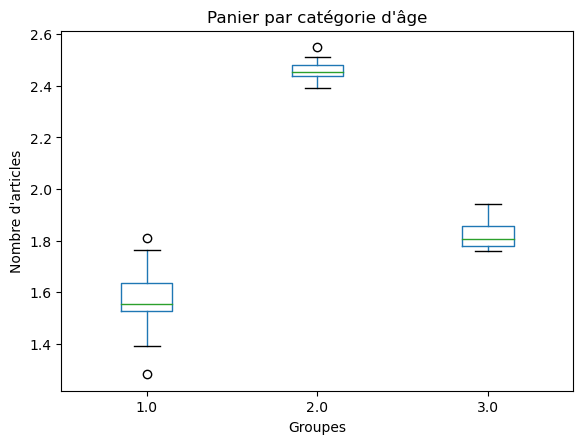

In [385]:
age_panier_moyen.boxplot('id_prod', by='groupe', grid=False)
plt.title( '''Panier par catégorie d'âge''' )
plt.ylabel('''Nombre d'articles''')
plt.xlabel('Groupes')
plt.suptitle('') 

### ANOVA

In [386]:
# Méthode 1
statf, pvalue = stats.f_oneway(age_panier_moyen['id_prod'][age_panier_moyen['groupe'] == 1], age_panier_moyen['id_prod'][age_panier_moyen['groupe'] == 2], age_panier_moyen['id_prod'][age_panier_moyen['groupe'] == 3])
statf, pvalue

(754.208170006363, 5.107348198689367e-49)

In [387]:
# Méthode 2
model = ols('id_prod ~ C(groupe)', data=age_panier_moyen).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

              sum_sq    df          F        PR(>F)
C(groupe)  10.765230   2.0  754.20817  5.107348e-49
Residual    0.513848  72.0        NaN           NaN


In [388]:
# Calcul de la valeur critique pour des degrés de liberté de 2 et 72
stats.f.ppf(q=1-0.05, dfn=2, dfd=72)

# Notre valeur F est largement au-dessus de la valeur critique

3.1239074485457783

#### Analyse Post-hoc

In [389]:
m_comp = pairwise_tukeyhsd(endog=age_panier_moyen['id_prod'], groups=age_panier_moyen['groupe'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   1.0    2.0   0.8878  -0.0  0.8331  0.9425   True
   1.0    3.0   0.2575   0.0  0.1915  0.3235   True
   2.0    3.0  -0.6303  -0.0 -0.7041 -0.5565   True
---------------------------------------------------


Toutes les paires rejettent l'hypothèse nulle

----

## Âge et catégorie

In [390]:
data_no_2004_grossiste.groupby('categ')['birth'].describe()

,count,mean,std,min,25%,50%,75%,max
categ,,,,,,,,
0,193503.0,1977.978031,11.309139,1929.0,1974.0,1980.0,1986.0,2003.0
1,99866.0,1973.362476,15.211421,1929.0,1963.0,1974.0,1985.0,2003.0
2,12835.0,1994.484768,9.854583,1930.0,1993.0,1996.0,2000.0,2003.0


### ANOVA

In [391]:
model = ols('birth ~ C(categ)', data=data_no_2004_grossiste).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq        df             F  PR(>F)
C(categ)  5.422062e+06       2.0  16906.007525     0.0
Residual  4.910210e+07  306201.0           NaN     NaN


In [392]:
# Calcul de la valeur critique pour des degrés de liberté de 2 et 306201
stats.f.ppf(q=1-0.05, dfn=2, dfd=306201)

# Notre valeur F est largement au-dessus de la valeur critique

2.9957615826891506

#### Post-hoc

In [393]:
m_comp = pairwise_tukeyhsd(endog=data_no_2004_grossiste['birth'], groups=data_no_2004_grossiste['categ'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -4.6156  -0.0 -4.7312 -4.4999   True
     0      2  16.5067  -0.0 16.2362 16.7773   True
     1      2  21.1223  -0.0  20.844 21.4006   True
---------------------------------------------------


#### Conclusions

H0 = "la moyenne des groupes sont égales" 

H1 = "Au moins, l'une des moyennes d'un groupe est différente des autres groupes"

Toutes les paires de groupe rejettent l'hypothèse H0. En d'autres termes : en fonction de la catégorie, la moyenne d'âge des acheteurs est différente.

### Visualisation de la distribution des données en fonctions des groupes

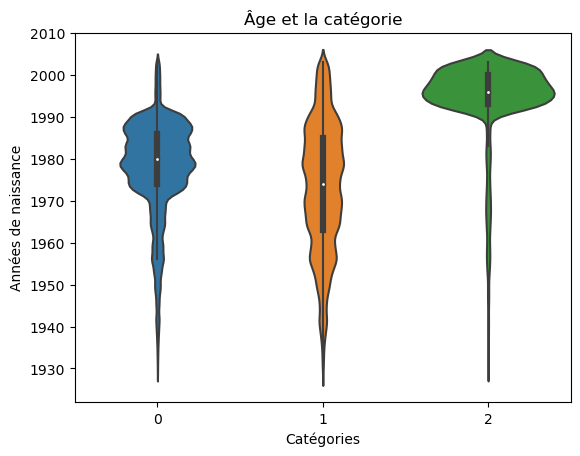

In [394]:
sns.violinplot(x='categ', y='birth', data=data_no_2004_grossiste)
plt.title('Âge et la catégorie')
plt.xlabel('Catégories')
plt.ylabel('Années de naissance')
plt.savefig('age_categ')
plt.show()

Catégorie 0 = concentration des données au sein de la tranche d'âge 1970 - 1990 (groupe de clients entre 30 et 50 ans)

Catégorie 1 = Les enregistrements s'étalent assez uniformément entre les différentes tranches d'âge

Catégorie 2 = Concentration des données au sein de la tranche d'âge inférieur à 1990 (les - de 30)

----

## Poids des groupes dans le chiffre d'affaires

In [395]:
total_ca_g1 = data_no_2004_grossiste[data_no_2004_grossiste['birth'] < 1972]['price'].sum()
total_ca_g2 = data_no_2004_grossiste[(data_no_2004_grossiste['birth'] > 1971)&(data_no_2004_grossiste['birth'] < 1992)]['price'].sum()
total_ca_g3 = data_no_2004_grossiste[data_no_2004_grossiste['birth'] > 1991]['price'].sum()
total_ca = data_no_2004_grossiste['price'].sum()

per_ca_g1 = total_ca_g1 / total_ca
per_ca_g2 = total_ca_g2 / total_ca
per_ca_g3 = total_ca_g3 / total_ca

per_ca_g1, per_ca_g2, per_ca_g3


(0.2646394933959289, 0.5066531722871443, 0.22870733431692644)

In [396]:
per_ca_g1+ per_ca_g2+ per_ca_g3

0.9999999999999997

---

## Courbe de Lorenz et coefficient de Gini

In [397]:
# CA par client
X = data.groupby('client_id')['price'].sum()
X = X.to_numpy()
X = np.sort(X) # tri des valeurs

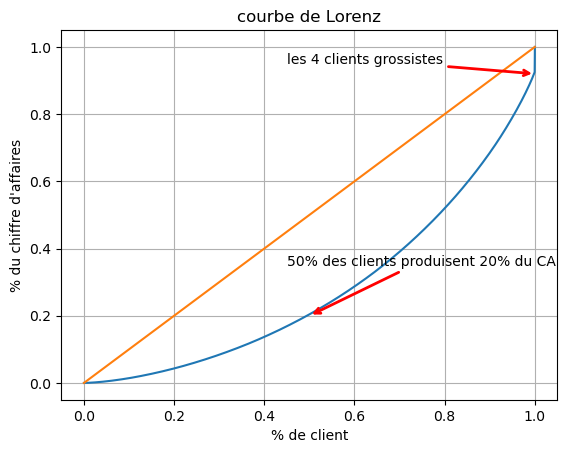

In [398]:
def lorenz(X):
    # On divis la somme cumulé par la somme 
    # afin avoir un résultat entre 0 et 1
    scaled_prefix_sum = X.cumsum() / X.sum()
    # On met en place la première valeur à 0
    return np.insert(scaled_prefix_sum, 0, 0)

lorenz_curve = lorenz(X)

plt.plot(np.linspace(0.0, 1.0, lorenz_curve.size), lorenz_curve)
# on affiche une ligne de 0,0 à 1,1
plt.plot([0,1], [0,1])
plt.xlabel('''% de client''')
plt.grid()
plt.ylabel('''% du chiffre d'affaires''')
plt.title('courbe de Lorenz')
plt.annotate('les 4 clients grossistes', xy=(1,0.92), xytext=(0.45,0.95),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.annotate('50% des clients produisent 20% du CA', xy=(0.5,0.2), xytext=(0.45,0.35),arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
plt.savefig('Lorenz')
plt.show()

In [399]:
# Calcul du coefficient de gini

n = X.size # Taille de l'échantillon
i = np.arange(1, n + 1) # Index commençant à 1


# Application de la formule
(np.sum((2 * i - n  - 1) * X)) / (n * np.sum(X))

0.43970990702750784